# Saint-Petersburg's realty market study

We have access to archive data from the [Yandex.Realty](https://realty.ya.ru/) service on apartments in St. Petersburg and neighboring settlements. The key objective is to learn how to determine market values of real estate. Study reslults might help to build an automated system to track anomalies and realty frauds. Some of these data were entered by service users, others were obtained automatically with Yandex GIS: distances to a settlement center, airport, nearest park or pond.

Our project is aimed to identify key parameters determining real estate market values.

Project plan:

1. Perform preliminary data analysis. 
2. Make exploratory data analysis (EDA) and preprocess the data:
    - identify missing values;
    - suggest possible explanations for missing data;
    - fill the missing values, if necessary;
    - identify columns with data types to be changed;
    - observe outliers;
    - calculate several realty parameters:
        - square meter price;
        - day of week, month and year when an ad was created;
        - floor categories;
        - proportions of apartment parts square footage.
3. Perform correlation analysis, graphic trend analysis.
4. Summarize findings.

Input data:

- `'airports_nearest'` — distance to a nearest airport (meters)
- `'balcony'` — how many balconies an apartment has 
- `'ceiling_height'` — ceiling height высота потолков (meters)
- `'cityCenters_nearest'` — distance to a settlement center (meters)
- `'days_exposition'` — how long an ad stayed from publication to taking out (days)
- `'first_day_exposition'` — date of ad publication
- `'floor'` — floor
- `'floors_total'` — how many floors are in a building
- `'is_apartment'` — is an apartment considered to serve strictly commercial purposes (bool)
- `'kitchen_area'` — kitchen square footage (square meters)
- `'last_price'` — price when an ad was taken out
- `'living_area'` — livable area square footage (square meters)
- `'locality_name'` — settlement name
- `'open_plan'` — if an appartment has an open layout (bool)
- `'parks_around3000'` — how many parks are within 3 kilometers distance
- `'parks_nearest'` — distance to a nearest park (meters)
- `'ponds_around3000'` — how many ponds or lakes are within 3 kilometers distance
- `'ponds_nearest'` — distance to a nearest pond or lake (meters)
- `'rooms'` — how many rooms an apartment has 
- `'studio'` — if an apartment is a studio (bool)
- `'total_area'` — total apartment square footage (square meters)
- `'total_images'` — how many aparment photos an ad contains

## First peek at the data

### Loading the data

Let's install and import all necessary libraries, functions and classes:

In [1]:
!pip install -q phik
!pip install -q skimpy
!pip install -q pymystem3

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from seaborn import heatmap

from skimpy import clean_columns

from statsmodels.tsa.seasonal import seasonal_decompose

from pymystem3 import Mystem

It's time to load the dataset into a dataframe. From a sneak peek we know, that tabulation is used to separate values. That's why we use the following `sep` value.

We define all possible paths to load data from:

In [3]:
path1 = '/datasets/'
path2 = '/Users/idrv/Yandex.Disk.localized/2022-Ya.Practicum/datasets/'
path3 = '/content/drive/MyDrive/Colab Notebooks/datasets/'
dataset_name = 'real_estate_data.csv'

`Try... except` construction is used to create the dataframe:

In [4]:
try:
    realty = pd.read_csv(path1 + dataset_name, sep='\t')
except FileNotFoundError:
    try:
        realty = pd.read_csv(path2 + dataset_name, sep='\t')
    except FileNotFoundError:
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            realty = pd.read_csv(path3 + dataset_name, sep='\t')
        except FileNotFoundError:
            print('File not found. Please, check the path!')

In [5]:
del path1, path2, path3, dataset_name

### Data structure

`info()` method is one of the easiest first steps to explore the data. We use it along with viewing first 5 dataframe rows:

In [6]:
realty.info()
realty.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


We should check the dataframe for full duplicates:

In [7]:
realty.duplicated().sum()

0

### Preliminary insights on the data

The dataset contains 23699 rows and 22 columns. Some columns have values missing, since it's count is less than 23699. These values seem to be `NaN`s. 

Almost all column names meet PEP8 recommendations, with four notable exceptions to be corrected: `'cityCenters_nearest'`, `'parks_around3000'`, `'parks_nearest'`, `'ponds_around3000'`.

Some columns will need data type to be converted: e.g., it doesn't seem necessary to keep prices in `float` with one deicaml point: even if a seller prefers to be THIS precise, that kind of precision is not heplful for our purposes.

Obvious duplicates are not found, but the missing values are to deal with. `'is_apartment'`, `'parks_nearest'` and `'ponds_nearest'` have lots of them, probably due to a lack of those in some neighborhoods and settlements. Anyway, some of the missing values will require data from other columns to be used in order to fill the `'NaN'`s.
 
After we define some functions, we rename the four aforemetioned columns according to the PEP8 and check every dataframe column a bit closer.

## Data prepocessing and EDA

### Defining analytical functions

We will need them for our convenience:

In [8]:
def quant_dist(dataframe, column, plot_size=(18,6)):
    '''
    The function provides text and graphic means of distribution analysis
    for a dataframe column containing quantitative values.
    It takes three arguments:
    1. dataframe: dataframe name.
    2. column: column's name as a string (e.g. 'column').
    3. plot_size: plot size for both plots in inches (figsize from matplotlib).
       Default is 18 by 3 (width by heigt).
        
    The function prints pd.DataFrame.describe() method results and draws
    two plots: a boxplot and a distribution histogram.
    '''
    
    print('Feature:', column)
    print(dataframe[column].describe())
    fig = plt.figure(figsize=plot_size)
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)
    ax1.set_title(f'Boxplot and distribution plot of {column} feature')
    dataframe.boxplot(column=column, vert=False, rot=90, ax=ax1, showmeans=True)
    dataframe.hist(column=column, bins='fd', yrot=90, ax=ax2)
    plt.show()
    print()

In [9]:
def sample_criterion(column, value):
    '''
    The function displays dataframe rows satisfying a user-defined criterion: 
    a user-specified column contains a certain value. The function can be used
    to identify observations containing outliers and unexpected values.
    It takes two arguments:
    1. column: a dataframe column as a Series object (e.g. dataframe['column']).
    2. value: a value being searched in the specified dataframe column.
    
    The function returns a random sample with 5 dataframe rows satysfying
    the criterion. If less then 5 rows were found, an error is raised.
    '''
    sample = realty.query('@column == @value')
    try:
        return sample.sample(n=5)
    except:
        print('Less then 5 rows were found, make a direct slice!')

In [10]:
def details(column, upper_limit):
    '''
    The function provides details on value distribution in a dataset column,
    if outliers are suspected. It takes two arguments:
    1. column: a dataframe column as a Series object (e.g. dataframe['column']).;
    2. upper_range: the upper value limit 
    
    The function draws a distribution histogram and prints pandas.describe() output.
    '''
    plt.figure(figsize=(8,4))
    column.hist(bins=100, range=(0, upper_limit))
    plt.title(f'{column.name} value distribution ranged from 0 to {upper_limit}')
    plt.show()
    return column.describe()

### Renaming the columns

In [11]:
realty = clean_columns(realty)
realty.columns

3 column names have been cleaned

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

All columns are named in a convenient way for further analysis.

### `'total_images'` — how many aparment photos an ad contains

We expect a column with discrete non-negative values. Let's check their spread and distribution with a boxplot and a histogram:

Feature: total_images
count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64


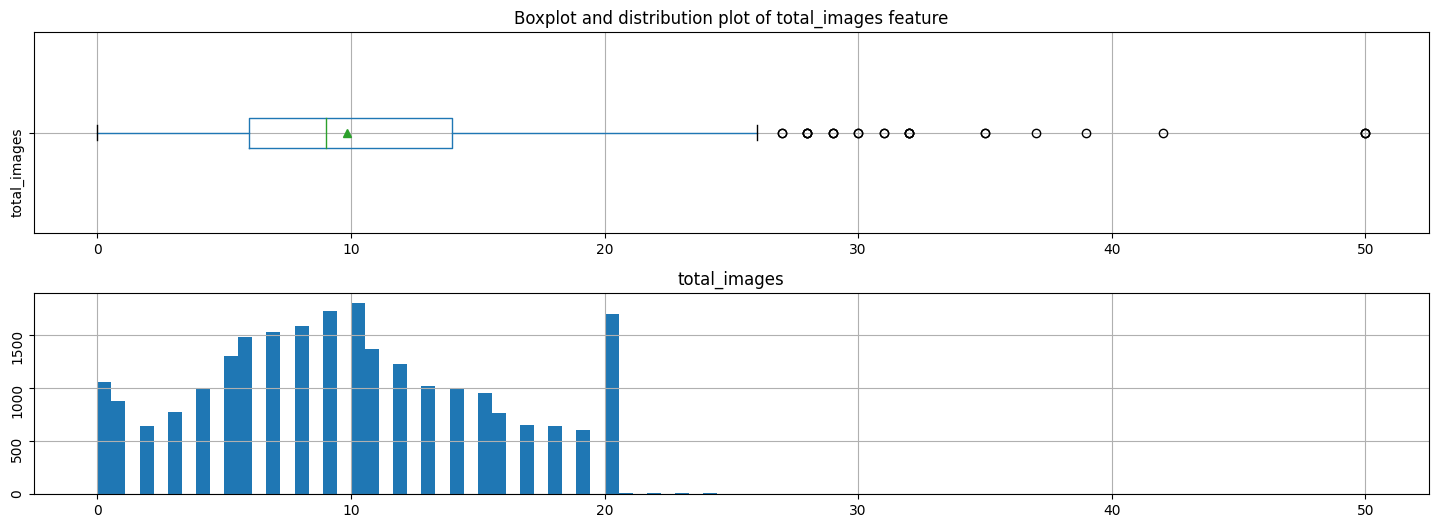

In [12]:
quant_dist(realty, 'total_images')

Most observations fit Poisson distribution, excepting outliers: zeroes and exactly 20 photos.

Probably we should check the latter obervations for anomalies. We start with 5 random ads without any images:

In [13]:
sample_criterion(realty['total_images'], 0)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
11250,0,2900000.0,57.0,2017-09-27T00:00:00,3,NaN,5.0,43.0,1,NaN,...,5.0,NaN,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,213.0
341,0,2950000.0,30.0,2017-11-21T00:00:00,1,2.50,9.0,16.0,5,NaN,...,7.0,NaN,Санкт-Петербург,14442.0,11734.0,1.0,641.0,1.0,84.0,168.0
5576,0,6680000.0,47.0,2017-12-11T00:00:00,1,2.80,25.0,29.0,3,NaN,...,10.0,1.0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,199.0
1477,0,3900000.0,56.8,2018-01-05T00:00:00,2,NaN,18.0,NaN,7,NaN,...,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
2089,0,6080000.0,55.0,2017-08-15T00:00:00,2,2.65,12.0,32.7,8,NaN,...,9.9,2.0,Санкт-Петербург,34270.0,11884.0,0.0,NaN,0.0,NaN,195.0


Nothing strange so far. What about 20 images?

In [14]:
sample_criterion(realty['total_images'], 20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
14220,20,8000000.0,38.7,2018-10-02T00:00:00,1,2.75,10.0,14.40,4,NaN,...,10.7,NaN,Санкт-Петербург,24281.0,5908.0,1.0,1270.0,2.0,474.0,42.0
125,20,4800000.0,65.9,2018-02-25T00:00:00,3,2.55,9.0,48.50,8,NaN,...,6.3,NaN,Санкт-Петербург,44855.0,17093.0,0.0,NaN,0.0,NaN,239.0
13124,20,1700000.0,33.5,2018-10-04T00:00:00,1,NaN,4.0,16.10,3,NaN,...,8.7,NaN,Волосово,NaN,NaN,NaN,NaN,NaN,NaN,57.0
10789,20,38900000.0,151.6,2018-03-06T00:00:00,4,NaN,9.0,63.31,5,NaN,...,56.0,NaN,Санкт-Петербург,26055.0,4800.0,1.0,648.0,1.0,779.0,106.0
4469,20,13975000.0,112.3,2018-10-29T00:00:00,3,2.80,21.0,67.00,6,NaN,...,14.0,2.0,Санкт-Петербург,27543.0,9432.0,0.0,NaN,2.0,376.0,155.0


Alles gut hier. 50 photos?

In [15]:
sample_criterion(realty['total_images'], 50)

Less then 5 rows were found, make a direct slice!


In [16]:
realty.query('total_images == 50')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
9778,50,11000000.0,87.0,2017-10-25T00:00:00,2,NaN,25.0,32.5,11,NaN,...,31.0,5.0,Санкт-Петербург,9586.0,11649.0,0.0,NaN,0.0,NaN,3.0
12667,50,20500000.0,76.0,2017-12-10T00:00:00,3,NaN,20.0,47.0,16,NaN,...,29.0,NaN,Санкт-Петербург,50812.0,16141.0,0.0,NaN,0.0,NaN,5.0
17396,50,14500000.0,119.7,2017-12-02T00:00:00,4,4.0,4.0,87.5,3,NaN,...,13.5,NaN,Санкт-Петербург,24375.0,2410.0,1.0,551.0,2.0,617.0,106.0


Nothing special again. These are normal ads with 50 apartment photos. Let's make an educatted guess. Most ad services put a limit on a number of pictures to upload. That explains the "20 images" anomaly. It's quite rare, that a user selects best 20 pictures, it's more of a bulk upload with a script limiting a number of files. But a script may fail. So, "50 pics" anomalies are probably caused by this kind of failure.

Since this feature is not critical in any analysis step, we leave these values as they were.

To optimize memory consumption it might be better to change the data type to `int8`:

In [17]:
realty['total_images'] = realty['total_images'].astype('int8')

Let us set an additional goal: we test if changing data type affects overall memory consumption. To do that we'll change data types wherever it's possible: either to date-time or to a lower bit width. After we're done with data preprocessing, the conclusion will be made: was it worth the effort?

### `'last_price'` — price when an ad was taken out

Feature: last_price
count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


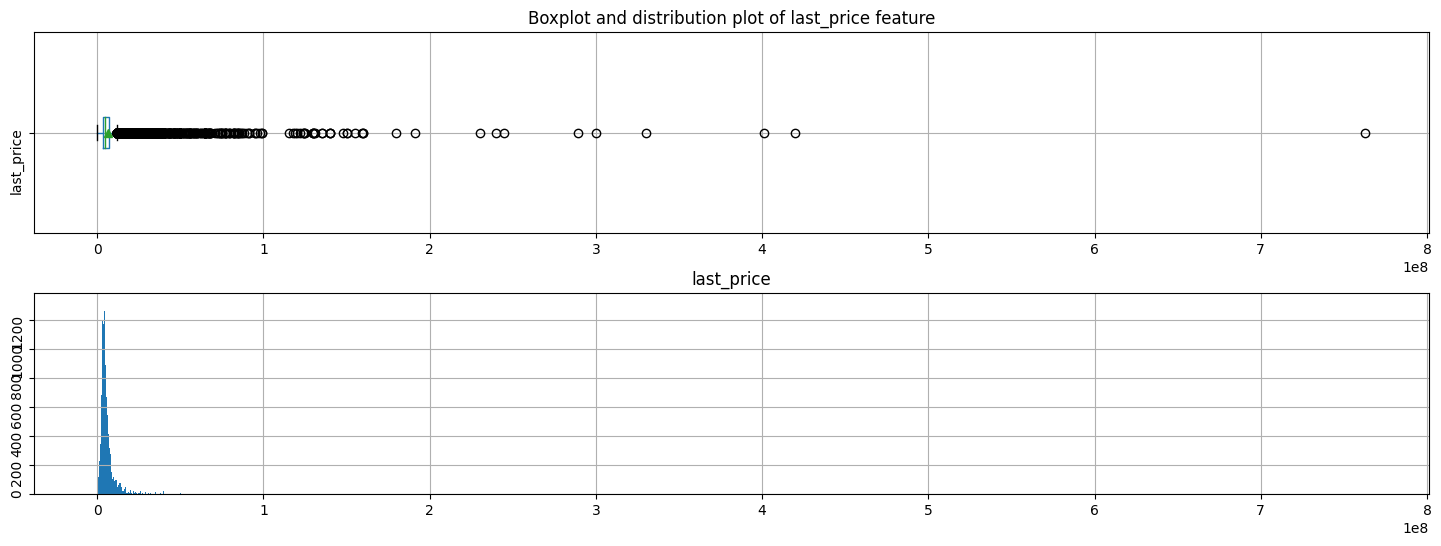

In [18]:
quant_dist(realty, 'last_price')

We observe serious outliers that distort the whole distribution picture. Taking a peek at a Top-10 of the most expensive realty in the dataset might provide us with some insights. For the sake simplicity we consider Euro to Russian ruble and US dollar to Russian ruble exchange rates even:

In [ ]:
realty.sort_values('last_price', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
12971,19,763000000.0,400.0,2017-09-30T00:00:00,7,NaN,10.0,250.0,10,NaN,...,NaN,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.80,25.0,409.7,25,NaN,...,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
14706,15,401300000.0,401.0,2016-02-20T00:00:00,5,NaN,9.0,204.0,9,False,...,24.0,3.0,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0
1436,19,330000000.0,190.0,2018-04-04T00:00:00,3,3.50,7.0,95.0,5,NaN,...,40.0,NaN,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0
15651,20,300000000.0,618.0,2017-12-18T00:00:00,7,3.40,7.0,258.0,5,NaN,...,70.0,NaN,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
22831,18,289238400.0,187.5,2019-03-19T00:00:00,2,3.37,6.0,63.7,6,NaN,...,30.2,NaN,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN
16461,17,245000000.0,285.7,2017-04-10T00:00:00,6,3.35,7.0,182.8,4,NaN,...,29.8,NaN,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249.0
13749,7,240000000.0,410.0,2017-04-01T00:00:00,6,3.40,7.0,218.0,7,NaN,...,40.0,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,199.0
5893,3,230000000.0,500.0,2017-05-31T00:00:00,6,NaN,7.0,NaN,7,NaN,...,40.0,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0
8900,13,190870000.0,268.0,2016-03-25T00:00:00,3,NaN,8.0,132.0,7,NaN,...,40.0,NaN,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,901.0


Prices at hundreds of million rubles (i.e. millions of Euros/dollars) are not a sick fantasy. Although the priciest realty is ₽340M (€/$5.3M) ahead of other contenders, it seems realistic: these prices could exist. And the data type might be changed to `integer`:

In [20]:
realty['last_price'] = realty['last_price'].astype('int32')

What about price distribution in a not so "hi-end" segment with a ₽20M upper limit?

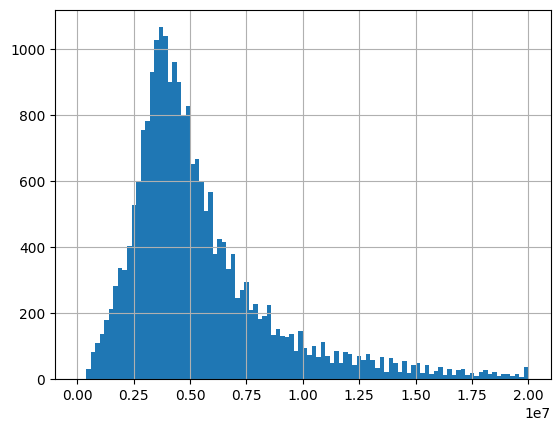

In [21]:
realty['last_price'].hist(bins=100, range=(0, 20000000))
plt.show()

₽3.5M (€/$ 55.5 thousand) peak divides the observations into two uneven groups:

In [22]:
realty['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

That seems more realistic. The median shows much more balanced prices around ₽4.65M (€/$7 3.6 thousand), while the value of the upper 75% of realty prices is closer to ₽6.8M (€107.8 thousand).

Of course, there are much more expensive offers, including extremly expensive ones. It's to be expected for St.Petersburg being a city with populaion of 5 million.

Do we have abnormally low price values?

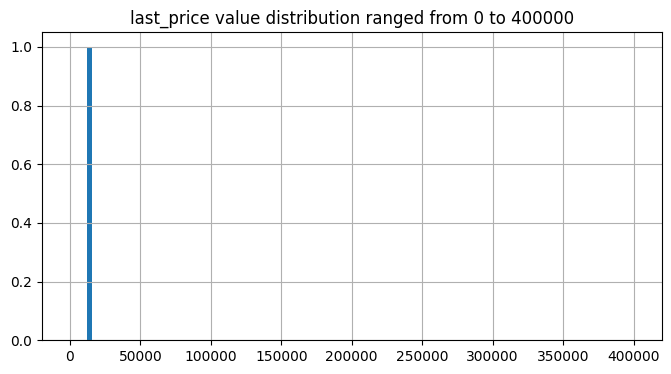

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [23]:
details(realty['last_price'], 400000)

Only one has been found:

In [24]:
realty[realty['last_price'] < 400000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
8793,7,12190,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,...,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


₽12190 (€/$195) for 1 bedroom apartment with 109 meters square footage on a 25th floor in St.Petersburg is not a fairy tale, it's a data error. A user probably entered the sum in thousands of roubles instead of just rubles. We can correct it:

In [25]:
realty.loc[8793, 'last_price'] *= 1000

### `'total_area'` — total apartment square footage (square meters)

Feature: total_area
count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


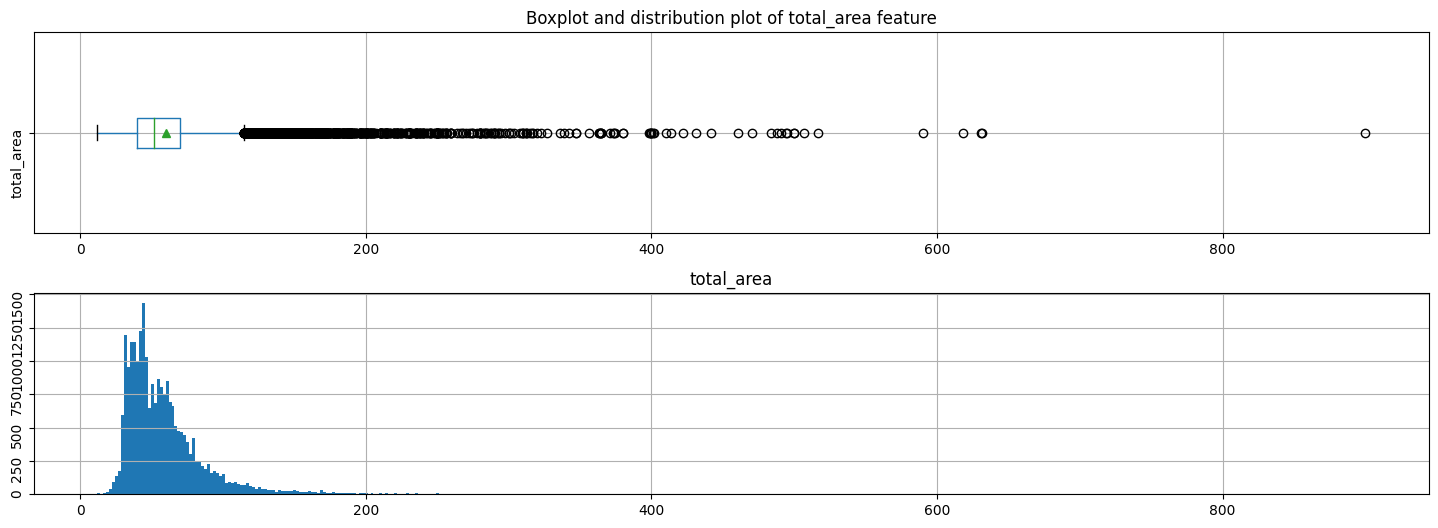

In [26]:
quant_dist(realty, 'total_area')

Once more we observe quite a diverse realty (in terms of square footage), including extremely spacy apartments. In order to get a better picture of the most salable objects a 200 square meters limit is placed and the resulting distribution is visualized:

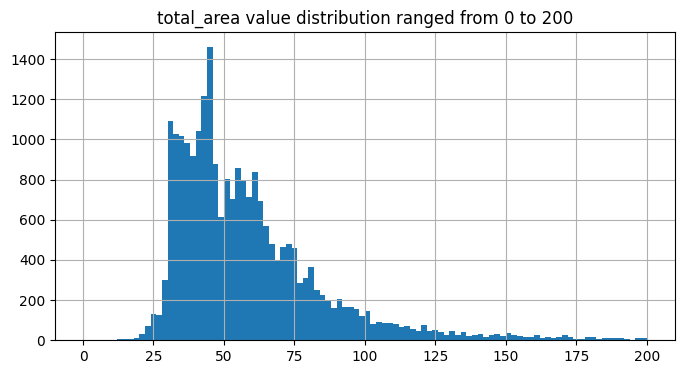

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

In [27]:
details(realty['total_area'], 200)

75% of all observations are in a range up to 70 square meters. Other 25% are unevenly distibuted within the 70-200 square meters range. The rest may be considered as extreme outliers.

### `'first_day_exposition'` — date of ad publication

Obviously teh data type is to be changed to date-time. No missing values are found, but we better to check the date range in order to avoid error values.

In [28]:
realty['first_day_exposition'] = pd.to_datetime(realty['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

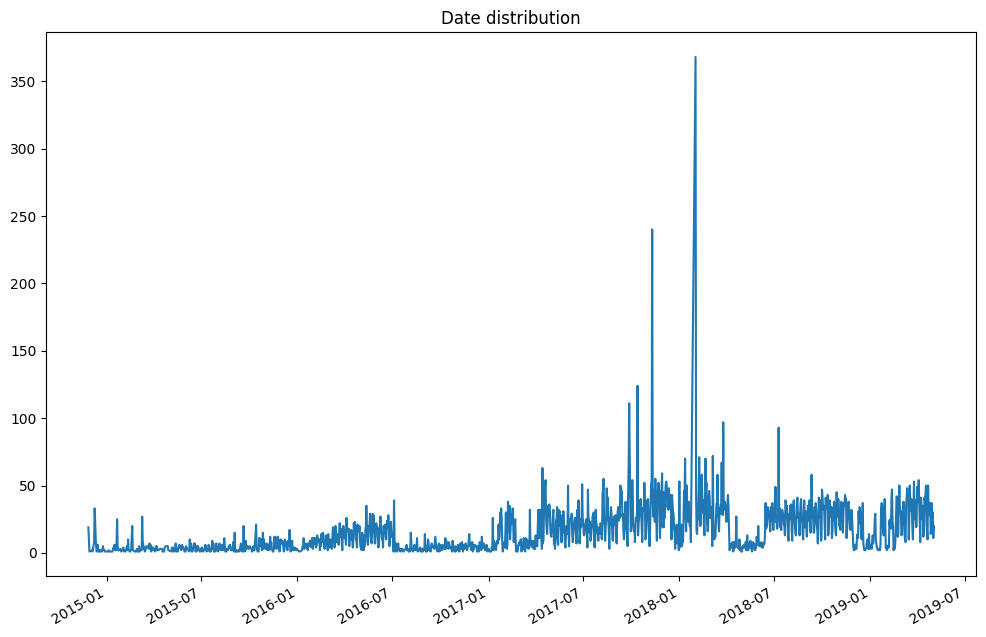

In [29]:
plt.figure(figsize=(12,8))
realty['first_day_exposition'].value_counts().plot(kind='line')
plt.title('Date distribution')
plt.show()

Everething looks fine. The end of 2014 (when first ads appeared) seemed to be a time the service was launched. After showing some growth in first half of 2016, the populartity somewhat declined; that could reflect a situation in the real estate market. Since 2017, the market started again to show an increase in supply with several peaks and a new collapse in the middle of 2018. The upper limit of observations is in April 2019.

### `'rooms'` — how many rooms an apartment has

This column contains no missing values. However, we should check it for observations that indicate "0 rooms" (if any): that may be true for commercial real estate (like hangars or some warehouses), but suspicious for residential housing.

Feature: rooms
count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


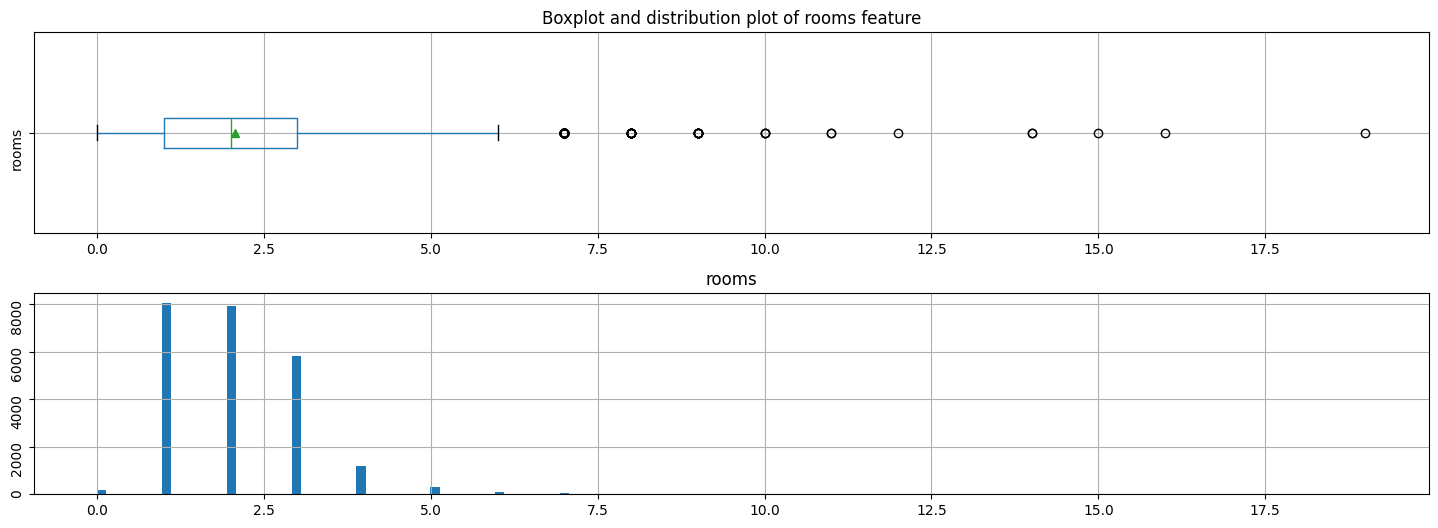

In [30]:
quant_dist(realty, 'rooms')

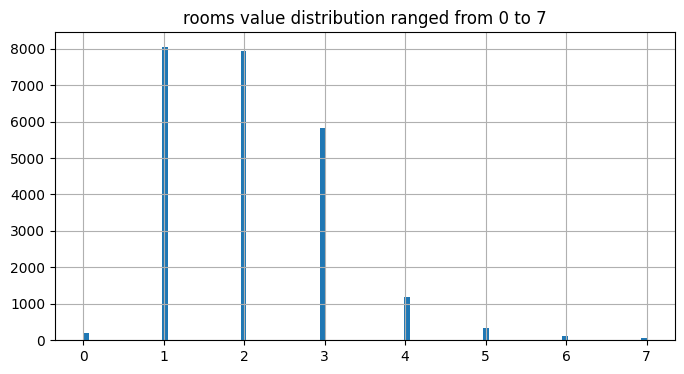

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [31]:
details(realty['rooms'], 7)

The vast majority of apartments have one or two rooms (**not bedrooms**: rooms in total). Three rooms apartments are rarer, but still present considerable share. A distribution "rule of thumb" is simple: the more rooms - the less ads.

Time to check those "zero rooms anomalies":

<AxesSubplot:ylabel='Frequency'>

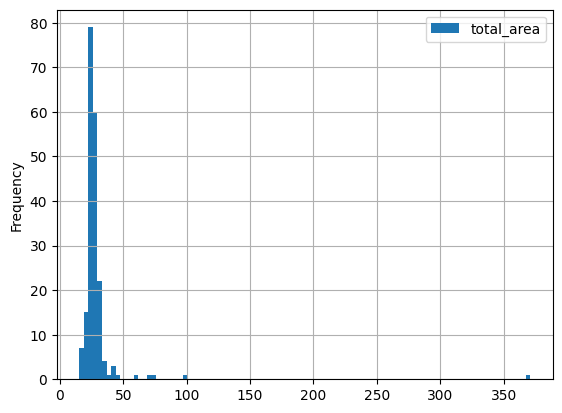

In [32]:
realty.query('rooms == 0').plot(y='total_area', grid=True, kind='hist',bins=100)

In [33]:
sample_criterion(realty['rooms'], 0)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
11051,2,2200000,26.00,2017-10-24,0,NaN,21.0,12.00,21,NaN,...,NaN,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,35.0
839,14,1900000,35.00,2017-04-14,0,2.7,5.0,15.00,3,False,...,NaN,1.0,поселок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,7.0
6364,5,2820000,27.81,2018-08-09,0,2.7,25.0,17.85,5,NaN,...,NaN,NaN,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,131.0
946,5,2200000,23.00,2016-09-27,0,NaN,27.0,18.00,7,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,483.0
608,2,1850000,25.00,2019-02-20,0,NaN,10.0,NaN,7,NaN,...,NaN,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0


These anomalies include all kinds of property (in terms of square footage):

In [34]:
realty.query('(rooms == 0) and (total_area > 50)').sort_values('total_area', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
19392,5,71000000,371.0,2018-07-26,0,3.57,7.0,NaN,6,NaN,...,NaN,NaN,Санкт-Петербург,25257.0,6060.0,1.0,761.0,1.0,584.0,90.0
20082,10,16300000,98.4,2017-11-08,0,3.10,5.0,60.5,2,NaN,...,NaN,NaN,Санкт-Петербург,26972.0,5819.0,0.0,NaN,1.0,674.0,537.0
3458,6,7400000,73.6,2017-05-18,0,NaN,3.0,50.0,1,NaN,...,NaN,0.0,Санкт-Петербург,26581.0,6085.0,0.0,NaN,1.0,348.0,60.0
21227,0,8200000,71.0,2017-07-21,0,5.80,5.0,68.0,5,NaN,...,NaN,0.0,Санкт-Петербург,20170.0,1261.0,2.0,295.0,3.0,366.0,30.0
13613,16,8100000,58.4,2019-04-26,0,3.30,7.0,33.0,6,NaN,...,NaN,NaN,Санкт-Петербург,14509.0,8288.0,0.0,NaN,0.0,NaN,NaN


The ad with the largest square footage does not have a *living* area, but shows large **total** area and an open layout. We can safely assume it being a commercial property, thus possibly having no rooms. The rest of the observations are studios.

Let's make test out a hypothesis; when filling out the ad form, some users get confused about how many rooms there are in a studio:

In [35]:
realty.query('studio == True').pivot_table(
    index='rooms', values='total_area', aggfunc=('count'))

,total_area
rooms,
0,138
1,11


Well, the hypothesis seems to be confirmed. What should we do?

Why don't we test another hypothesis: zero number of rooms is connected to facts of an apartment being a studio and/or having an open layout? "Studio - Open plan" comblination takes one of four possible values:

In [36]:
for studio in (True, False):
    for open_plan in (True, False):
        query = realty.query('(rooms == 0) and (studio == @studio) and (open_plan == @open_plan)')['rooms'].count()
        print(f'Studio = {studio}, Open plan = {open_plan}:', query)

Studio = True, Open plan = True: 0
Studio = True, Open plan = False: 138
Studio = False, Open plan = True: 59
Studio = False, Open plan = False: 0


Ads with neither zero rooms AND an open layout, nor with zero rooms NOT being a studio AND NOT having an open layout have been found.

What has been found, are apartments with **yet** zero rooms AND NOT being studios.

Therefore, the hypothesis has been confirmed: there's a certain connection. If sellers define a property a studio, they never consider it having an open layout. The converse is alsi tru: if an apartment considered having an open layout, it's not called "a studio" **yet**.

So, whether a studio has a room or not is ambiguous. Realty sellers approach this question in two opposite manners. In order to resolve the ambiguity for our purposes we pronounce all studios having 1 room:

In [37]:
realty['rooms'] = realty['rooms'].mask(
    (realty['rooms'] == 0) & (realty['studio'] == True) & (realty['open_plan'] == False), other=1)

realty['rooms'] = realty['rooms'].astype('int8')

In [38]:
del studio, open_plan

### `'ceiling_height'` — ceiling height (meters)

Feature: ceiling_height
count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


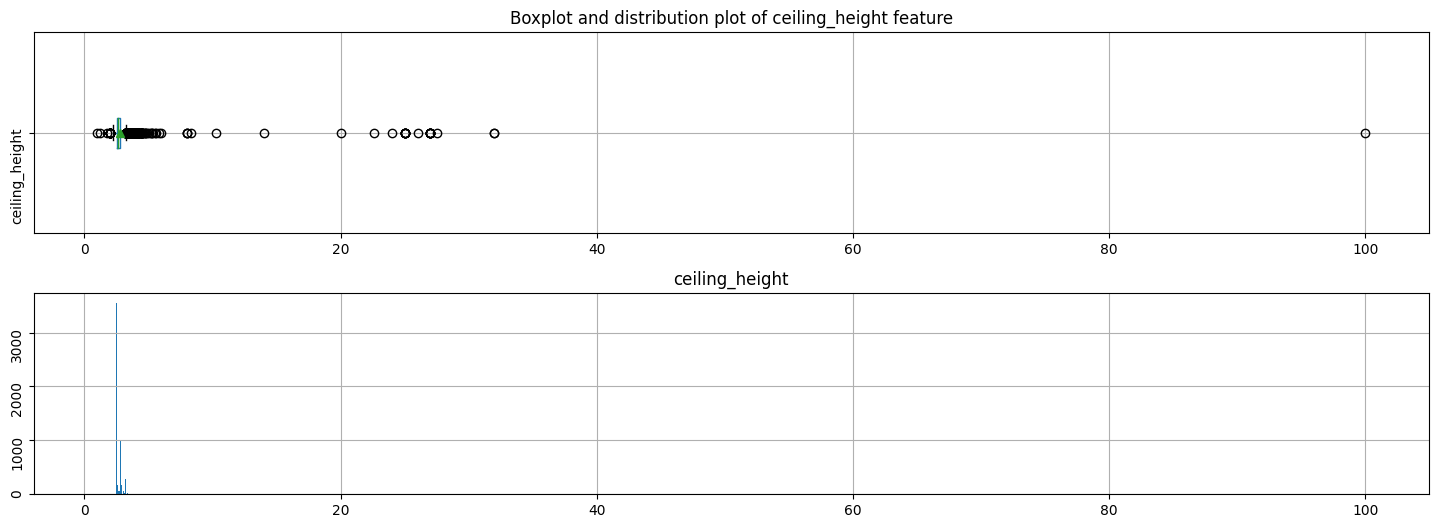

In [39]:
quant_dist(realty, 'ceiling_height')

We seem be dealing with some data errors. Ceiling height over 10 meters? Possible in commercial buildings (shopping malls, office centers, gyms, workshops, warehouses etc.), but rather unlikely elsewere. Let's place a 5 meters limit:

In [40]:
realty.query('ceiling_height > 5').head().sort_values('last_price', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
1026,20,155000000,310.0,2018-10-12,5,5.3,3.0,190.0,3,NaN,...,63.0,2.0,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
464,15,66571000,280.3,2015-06-11,6,5.2,8.0,159.5,7,NaN,...,21.1,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
1388,20,59800000,399.0,2015-01-21,5,5.6,6.0,NaN,6,NaN,...,NaN,0.0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
355,17,3600000,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000,75.0,2018-11-12,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Judging by the prices, all ads with ceiling heights from 5 to 6 meters are somewhat of luxury or commercial real estate. Anything above 6 meters is listed as residential property, pretty standard in everything but ceiling heights. Conclusion: all above 6 meters is a simple mistyping result. Suggested action: since there is no additional data to help in guessing correct heights, to replace errors with a median ceiling height, calculated for the entire dataset.

In [41]:
realty['ceiling_height'] = realty['ceiling_height'].mask(
    (realty['ceiling_height'] > 6), other=realty['ceiling_height'].median())

The same approach is used for missing values:

In [42]:
realty['ceiling_height'] = realty['ceiling_height'].fillna(
    realty['ceiling_height'].median())

realty['ceiling_height'] = realty['ceiling_height'].astype('float32')

### `'floors_total'` — how many floors are in a building

Feature: floors_total
count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


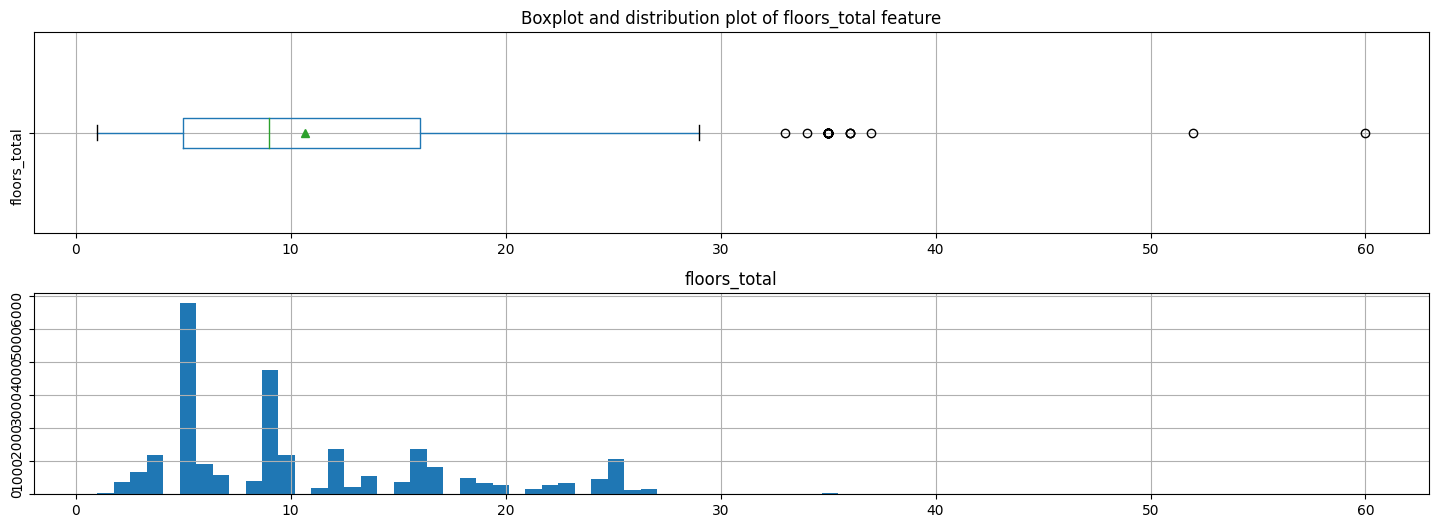

In [43]:
quant_dist(realty, 'floors_total')

That's a perfectly understandable distribution. Peaks at five and nine floors are quite expected, that's a common height for (post-)soviet apartment buldings. As for the lack of 11 and 13-floors buildings, there are virtually no buildings of those heights. Let's take a closer look at all observations above 25 floors:

In [44]:
realty.query('floors_total > 25').sort_values('floors_total', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
2253,12,3800000,45.5,2018-06-28,2,2.88,60.0,27.4,4,NaN,...,7.40,NaN,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
16731,9,3978000,40.0,2018-09-24,1,2.65,52.0,10.5,18,NaN,...,14.00,NaN,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0
16934,5,4100000,40.0,2017-10-17,1,1.75,37.0,17.4,5,NaN,...,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
5807,17,8150000,80.0,2019-01-09,2,2.65,36.0,41.0,13,NaN,...,12.00,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
397,15,5990000,54.0,2018-03-22,2,2.65,36.0,21.4,28,NaN,...,18.70,1.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,11.0
11079,16,9200000,75.0,2019-02-22,2,2.70,36.0,40.0,29,NaN,...,12.00,2.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,NaN
12888,7,7600000,70.0,2016-11-18,3,2.70,35.0,36.5,27,NaN,...,23.10,2.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,413.0
22946,14,7690000,75.0,2018-03-27,2,2.65,35.0,40.0,8,NaN,...,15.00,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,NaN
13975,19,6990000,65.0,2018-10-06,2,2.65,35.0,32.1,23,NaN,...,8.90,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,89.0
2966,9,4300000,37.0,2017-08-08,1,2.65,35.0,14.0,15,NaN,...,10.40,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,50.0


The first entry is hardly true: there are no 60 floors buildings in Kronstadt (St.Petersburg suburb). Probably, it's just a typo: `6` floors should be listed instead.

The same doubts are raised by the second entry. In St. Petersburg, there are no buildings of such height, where realty would be sold even at the moment of conducting this study, and the cost of this offer is way below the "high-floor" segment. A typo is also likely here: instead of `25`, the author of the ad typed `52`.

Ads for buildings 37, 36 and 35 floors tall refer to buildings located side by side, judging by the columns `'airports_nearest'`, `'city_centers_nearest'` and `'parks_nearest'`. It's difficult to recover their true height, and probably unnecessary. We'll just take care of the first two outliers:

In [45]:
realty.loc[2253, 'floors_total'] = 6
realty.loc[16731, 'floors_total'] = 25

Now we should deal with the missing values. This information may be important to us, so it is necessary to fill them. Ii might be convenient to use median values from the entire sample. However, that way the situation is possible, when the `'floor'` value from the ad may be greater than the median value. So, we set a condition. If the property's floor value is greater than the median, we set the `'floors_total'` value equal to the `'floor'` value (as if the property was on the last floor). If it's less than the median, we set the median value for the `'floors_total'`. Let's define a function for that:

In [46]:
def floors_total_fillna(row):
    '''
    The function fills missing values in the 'floors_total' column. It takes the only argument:
    1. row: dataframe row.

    The function checks if the row meets two conditions, and returns either
    a median value for the 'floors_total' column or a corresponding value
    from a 'floor' row. 
    '''
    floors_median = realty['floors_total'].median()
    if pd.isna(row['floors_total']) == True:
        if row['floor'] > floors_median:
            return row['floor']
        else:
            return floors_median
    else:
        return row['floors_total']

In [47]:
print('Missing values before:', realty['floors_total'].isna().sum())
realty['floors_total'] = realty.apply(floors_total_fillna, axis=1)
print('Missing values after :', realty['floors_total'].isna().sum())

Missing values before: 86
Missing values after : 0


### `'living_area'` — livable area square footage (square meters)

Feature: living_area
count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64


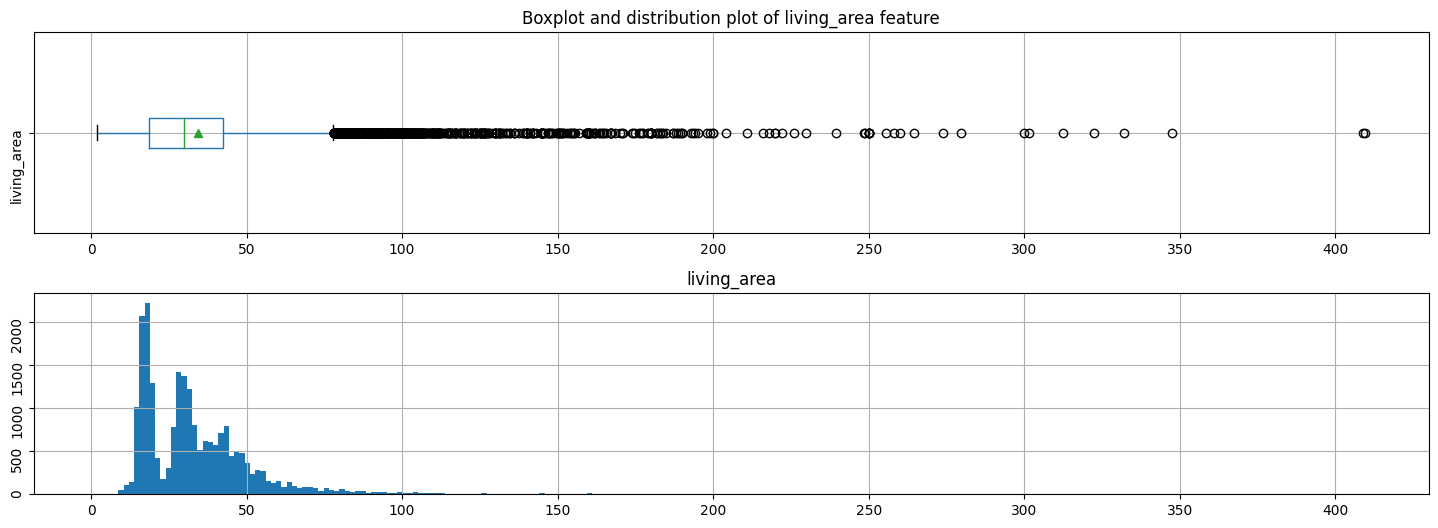

In [48]:
quant_dist(realty, 'living_area')

We observe lots of outliers again. Let's examine the ads with a square footage greater that 200 square meters: 

In [49]:
realty.query('living_area > 200').sort_values('floors_total', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
19540,8,420000000,900.0,2017-12-06,12,2.80,25.0,409.7,25,NaN,...,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
6621,20,99000000,488.0,2017-04-09,5,2.95,20.0,216.0,17,NaN,...,50.0,NaN,Санкт-Петербург,27641.0,4598.0,1.0,646.0,1.0,368.0,351.0
12971,19,763000000,400.0,2017-09-30,7,2.65,10.0,250.0,10,NaN,...,NaN,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0
22494,7,91075000,491.0,2017-05-27,5,4.20,9.0,274.0,9,NaN,...,45.0,0.0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,115.0
15701,12,83000000,293.6,2017-11-10,4,2.65,9.0,250.0,7,NaN,...,35.0,NaN,Санкт-Петербург,25593.0,5913.0,2.0,164.0,0.0,NaN,NaN
14706,15,401300000,401.0,2016-02-20,5,2.65,9.0,204.0,9,False,...,24.0,3.0,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0
21955,19,130000000,431.0,2017-10-02,7,3.70,8.0,220.0,5,NaN,...,20.0,5.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,161.0
14088,8,51000000,402.0,2017-02-07,6,3.15,8.0,300.0,6,NaN,...,56.0,2.0,Санкт-Петербург,24484.0,5052.0,1.0,253.0,0.0,NaN,32.0
7857,11,150000000,230.0,2017-10-25,8,2.65,8.0,220.0,8,NaN,...,NaN,NaN,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,135.0
12401,20,91500000,495.0,2017-06-19,7,4.65,7.0,347.5,7,NaN,...,25.0,0.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,14.0


Nothing outstanding. Just in case, we perform another check: we shouldn't find any observations, where a `'living_area'` value is greater that a `'total_area'` value:

In [50]:
realty.query('living_area > total_area')['living_area'].count()

0

The check came clear. Now we look closer to ads with square footage less than 100 square meters: 

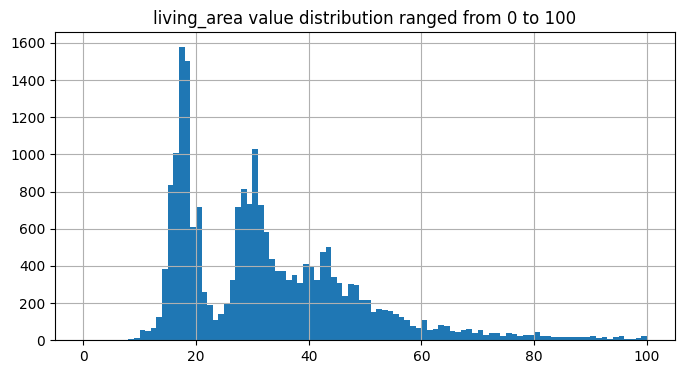

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [51]:
details(realty['living_area'], 100)

The distribution brings no surprises. The most property is quite small, below 20 and from 28 to 34 squafe meters.

Let's investigate the missing values:

In [52]:
realty[realty['living_area'].isna() == True].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
3,0,64900000,159.0,2015-07-24,3,2.65,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
7,5,7915000,71.6,2019-04-18,2,2.65,24.0,NaN,22,NaN,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
30,12,2200000,32.8,2018-02-19,1,2.65,9.0,NaN,2,NaN,...,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000,45.8,2017-10-28,2,2.50,5.0,NaN,1,NaN,...,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000,40.0,2018-11-18,1,2.65,22.0,NaN,3,NaN,...,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN


The subsample contains a variety of ads with different square footage and quantity of rooms. It's not that we can just fill the missing values with the median. Therefore, the following decision has been made: we copy the `'living_area'`, `'total_area'`, `'kitchen_area'`, and `'studio'` columns into a temporary dataset (the last two are needed a bit later, as the column `'kitchen_area'` also has missing values). A column for categorical values will also be created in that temporary dataset. Categorization will be carried according the square footage; then median values for a living area square footage will be calculated, and the missing values will be filled with these medians, depending on the category of the property according to the total square footage.

In [53]:
area = realty[['total_area', 'living_area', 'kitchen_area', 'studio']].copy()

In [54]:
def total_area_categories(total_area):
    '''
    The function catogorizes observations based on a 'total area' column value.
    It takes the only argument:
    1. total_area: total area value.

    The function returns one categorical value from this list:
    - '<20'
    - '20-35'
    - '35-45'
    - '45-60'
    - '60-80'
    - '80-100'
    - '100-200'
    - '>200'
    '''
    if total_area < 20:
        return '<20'
    if 20 <= total_area < 35:
        return '20-35'
    if 35 <= total_area < 45:
        return '35-45'
    if 45 <= total_area < 60:
        return '45-60'
    if 60 <= total_area < 80:
        return '60-80'
    if 80 <= total_area < 100:
        return '80-100'
    if 100 <= total_area < 200:
        return '100-200'
    if 200 <= total_area:
        return '>200'

In [55]:
area.loc[:, 'total_area_category'] = area.loc[:, 'total_area'].apply(total_area_categories)

Now we calculate median values of the living area square footage for each category:

In [56]:
total_area_medians = area.groupby('total_area_category')['total_area'].median()
print(total_area_medians)

total_area_category
100-200    120.0
20-35       31.4
35-45       40.0
45-60       52.0
60-80       67.4
80-100      87.3
<20         17.6
>200       250.0
Name: total_area, dtype: float64


In [57]:
def living_area_fillna(row):
    """
    The function performs a check, if a 'living_area' column value is missing.
    It takes the only argument:
    1. row: a dataframe row to check the value of the 'living_area' column.

    If the check returns True, the function returns a median value
    for a corresponding category from a 'total_area_category' column. 
    """
    if pd.isna(row['living_area']) == True:
        if row['total_area_category'] == '<20':
            return total_area_medians['<20']
        elif row['total_area_category'] == '20-35':
            return total_area_medians['20-35']
        elif row['total_area_category'] == '35-45':
            return total_area_medians['35-45']
        elif row['total_area_category'] == '45-60':
            return total_area_medians['45-60']
        elif row['total_area_category'] == '60-80':
            return total_area_medians['60-80']
        elif row['total_area_category'] == '80-100':
            return total_area_medians['80-100']
        elif row['total_area_category'] == '100-200':
            return total_area_medians['100-200']
        elif row['total_area_category'] == '>200':
            return total_area_medians['>200']
    return row['living_area']

In [58]:
print('Missing values before:', area['living_area'].isna().sum())
area.loc[:, 'living_area'] = area.apply(living_area_fillna, axis=1)
print('Missing values after :', area['living_area'].isna().sum())

Missing values before: 1903
Missing values after : 0


And we're done! The most likely cause of the missing values is that this field was omitted when the observation was created.

Now we should merge our results with the original dataset. However, we will need the temporary dataframe again when we analyze the kitchen square footage. So, we'll wait for a little longer with merging.

In [59]:
del total_area_medians

### `'floor'` — floor

Feature: floor
count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


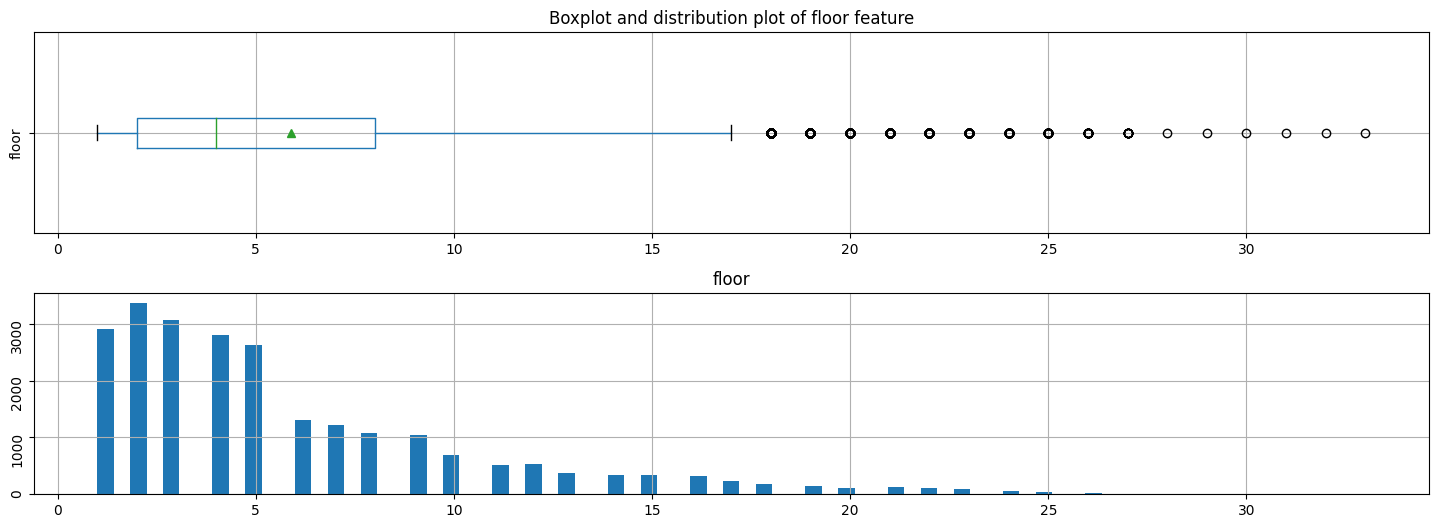

In [60]:
quant_dist(realty, 'floor')

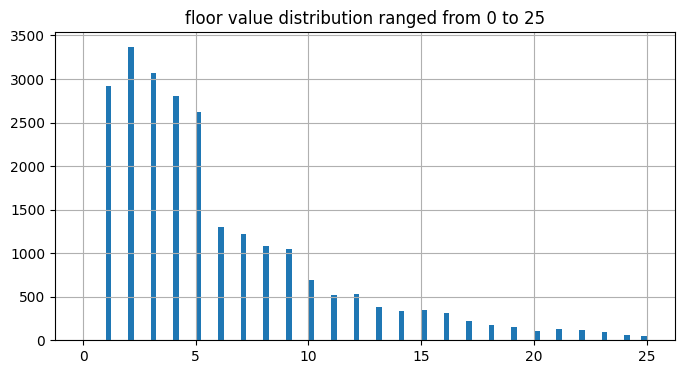

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

In [61]:
details(realty['floor'], 25)

No surprises here. The most advertised property is on floors 1 to 5; that's the only thing for sure.

### `'is_apartment'` — is an apartment considered to serve strictly commercial purposes (bool)

# Bookmark

Про эти данные мы знаем, что они относятся к типу boolean. Посмотрим на распределение значений:

In [62]:
realty['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Судя по всему, далеко не все авторы объявлений утруждали себя указанием "мой объект - не аппартаменты". Кажется, уместно будет заполнить все пропуски значением `'False'`. Кроме того, этот столбец хранит данные в виде строк, что вряд ли оптимально с точки зрения использования памяти:

In [63]:
realty.loc[:, 'is_apartment'] = realty.loc[:, 'is_apartment'].fillna(False).astype('bool')

/var/folders/z9/nxf9mlds6rlgnch0_jb60f800000gn/T/ipykernel_56267/1551976703.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  realty.loc[:, 'is_apartment'] = realty.loc[:, 'is_apartment'].fillna(False).astype('bool')


### `'studio'` — if an apartment is a studio (bool)

In [64]:
realty['studio'].value_counts()

False    23550
True       149
Name: studio, dtype: int64

Вмешательства не требуется. Изменение типа переменных здесь только увеличивает использование памяти, поэтому не делаем этого.

### `'open_plan'` — if an appartment has an open layout (bool)

In [65]:
realty['open_plan'].value_counts()

False    23632
True        67
Name: open_plan, dtype: int64

Та же ситуация. Никаких отдельных действий не требуется.

### `'kitchen_area'` — kitchen square footage (square meters)

Feature: kitchen_area
count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64


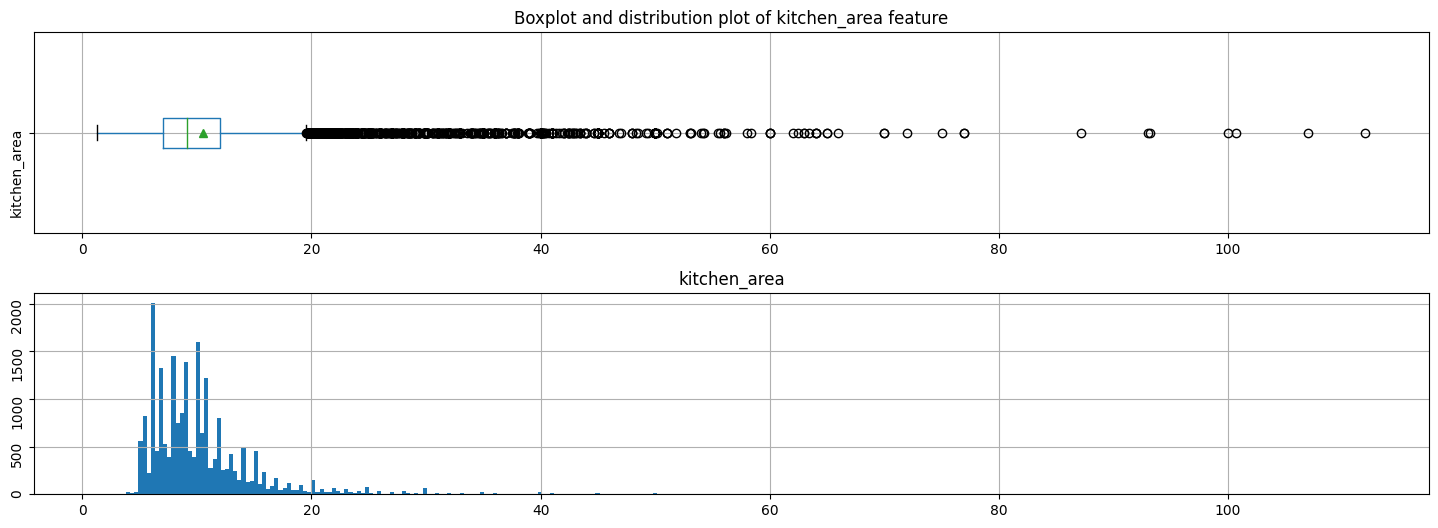

In [66]:
quant_dist(realty, 'kitchen_area')

Какими большими бывают кухни! Это возможно (например, если речь идет о столовой с готовочной зоной), но всё равно требует более пристального взгляда:

In [67]:
realty.query('kitchen_area > 40')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
51,7,45000000,161.0,2017-10-17,3,3.20,8.0,38.0,4,False,...,50.0,NaN,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0
263,12,39900000,140.6,2016-11-19,2,3.50,8.0,39.8,7,False,...,49.2,4.0,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,NaN
492,18,95000000,216.0,2017-12-05,4,3.00,5.0,86.0,4,False,...,77.0,NaN,Санкт-Петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0
511,7,5950000,69.0,2017-12-21,1,2.65,16.0,13.0,12,False,...,50.0,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21923,10,115490000,235.0,2017-04-09,5,4.90,5.0,140.0,5,False,...,50.0,NaN,Санкт-Петербург,22777.0,1328.0,3.0,652.0,3.0,253.0,351.0
22494,7,91075000,491.0,2017-05-27,5,4.20,9.0,274.0,9,False,...,45.0,0.0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,115.0
22980,19,24500000,155.4,2017-10-10,3,3.00,4.0,72.0,2,False,...,65.0,NaN,Санкт-Петербург,43758.0,15461.0,1.0,756.0,2.0,278.0,325.0
23327,19,34400000,215.0,2019-03-15,5,2.75,4.0,82.4,4,False,...,40.1,NaN,Санкт-Петербург,37268.0,15419.0,0.0,NaN,0.0,NaN,NaN


Кажется, в некоторые данные все-таки вкрались ошибки. Сложно представить себе кухню площадью 50 м² в квартире площадью 69 м². В целом можно предположить, что есть связь между площадью квартиры и площадью кухни:

In [68]:
realty[['total_area', 'kitchen_area']].corr()

,total_area,kitchen_area
total_area,1.000000,0.609121
kitchen_area,0.609121,1.000000


Связь есть, хотя и не столь сильная, как можно было надеяться. Попробуем найти среднее отношение площади кухни к общей площади недвижимости:

In [69]:
area['kitchen_to_total_ratio'] = area['kitchen_area'] / area['total_area']
area['kitchen_to_total_ratio'].describe()

count    21421.000000
mean         0.187355
std          0.072968
min          0.025381
25%          0.133333
50%          0.172414
75%          0.232416
max          0.787879
Name: kitchen_to_total_ratio, dtype: float64

Среднее и медианное значения этого отношения красноречиво свидетельствуют, что ситуация, описанная выше (50 м² кухни при 69 м² общей площади) - далека от типичной в выборке. Будем исходить из предположения: некоторые данные были введены некорректно и требуют корректировки.
Внимательный просмотр записей, в которых выведенное нами отношение превышает IQR, позволило выявить источник многих ошибок. В датасете немало записей, в которых площадь кухни превышает жилую площадь. Скорее всего авторы этих объявлений банально перепутали поля, вписав в жилую площадь площадь кухни и наоборот. Определим такие записи и "поменяем местами" в них значения жилой и кухонной площадей.

In [70]:
area.query('kitchen_area > living_area')['kitchen_area'].count()

355

In [71]:
def living_swap(row):
    if row['kitchen_area'] > row['living_area']:
        living_area_swap = row['kitchen_area']
        return living_area_swap
    return row['living_area']

def kitchen_swap(row):
    if row['kitchen_area'] > row['living_area']:
        kitchen_area_swap = row['living_area']
        return kitchen_area_swap
    return row['kitchen_area']

In [72]:
area['living_area'] = area.loc[:].apply(living_swap, axis=1)
area['kitchen_area'] = area.loc[:].apply(kitchen_swap, axis=1)

In [73]:
area.query('kitchen_area > living_area')['kitchen_area'].count()

0

Теперь заполним отсутствующие значения. Поскольку нам удалось рассчитать среднее отношение площади кухни к общей площади, вычислим примерную площадь кухни на основе этого среднего значения: 

In [74]:
def kitchen_area_fillna(row):
    '''
    The function fills missing values in the 'kitchen_area' column.
    It takes the only argument:
    1. row: dataframe row.

    The function checks if a value is missing, and returns a new value based
    on kitchen area to total area ratio and a mean value of all kitchen areas.
    '''
    kitchen_mean = area['kitchen_to_total_ratio'].describe()['mean']
    if pd.isna(row['kitchen_area']) == True:
        kitchen_estimate = row['total_area'] * kitchen_mean
        return kitchen_estimate
    return row['kitchen_area']

In [75]:
print('Missing values before:', area['kitchen_area'].isna().sum())
area.loc[:, 'kitchen_area'] = area.apply(kitchen_area_fillna, axis=1)
print('Missing values after :', area['kitchen_area'].isna().sum())

Missing values before: 2278
Missing values after : 0


Наконец, округлим значения площади кухни до одного знака после запятой и перенесем все значения столбцов `'living_area'` и `'kitchen_area'`, в которые мы вносили изменения, обратно из вспомогательного датафрейма в основной:

In [76]:
area['kitchen_area'] = round(area['kitchen_area'], 1)

realty[['living_area', 'kitchen_area']] = area[['living_area', 'kitchen_area']]

Ну и раз уж мы взялись периодически пытаться оптимизировать память, надо бы удалить датафрейм `'area'`, поскольку методом `'.copy()'` мы создали прямо его копию, а не символическую ссылку. Однако он еще пригодится нам, поэтому сделаем это позже.

Последнее действие, которое необходимо выполнить - заполнить пропуски, которые присутствие `'NaN'` оставило в столбце `'kitchen_to_total_ratio'`. Просто еще раз повторим уже однажды проделанное действие, для удобства просмотра округлив значения до второго знака после запятой:

In [77]:
area['kitchen_to_total_ratio'] = round((area['kitchen_area'] / area['total_area']), 2)

### `'balcony'` — how many balconies an apartment has

Feature: balcony
count    12180.000000
mean         1.150082
std          1.071300
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64


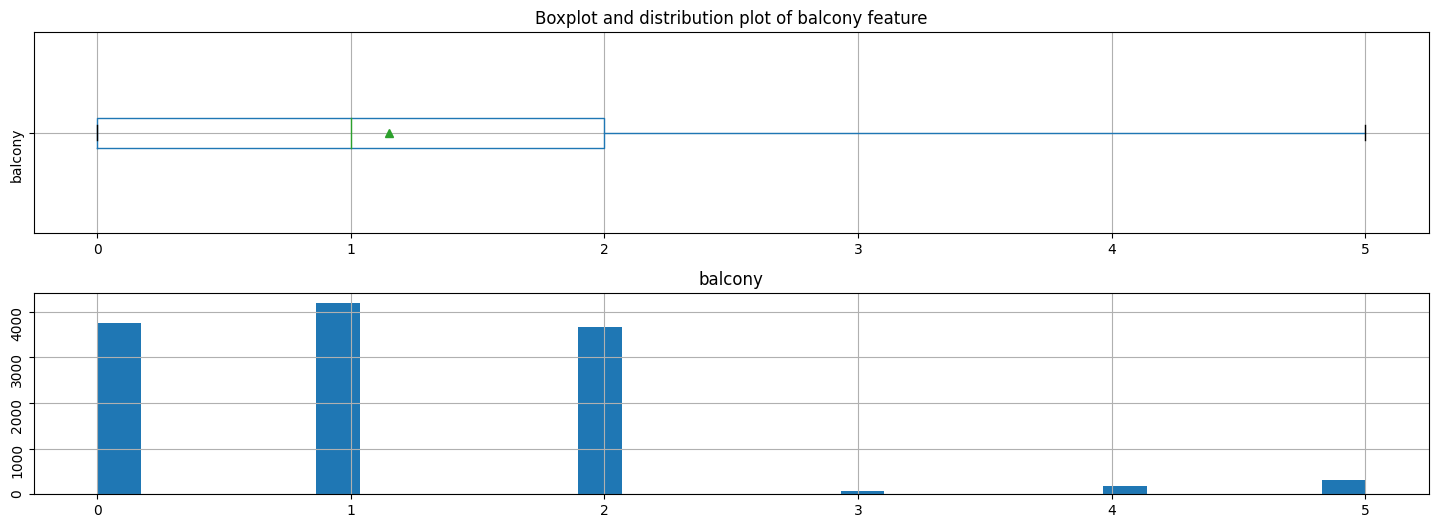

In [78]:
quant_dist(realty, 'balcony')

Полюбопытствуем, в каких квартирах больше двух балконов:

In [79]:
sample_criterion(realty['balcony'], 3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
13242,13,4950000,58.1,2018-08-05,3,2.50,9.0,39.6,5,False,...,6.2,3.0,Санкт-Петербург,51091.0,16419.0,0.0,NaN,0.0,NaN,60.0
18712,20,9100000,68.5,2018-05-05,2,3.30,6.0,30.0,6,False,...,19.0,3.0,Пушкин,18879.0,31036.0,0.0,NaN,1.0,391.0,NaN
524,10,3800000,74.4,2017-05-18,3,2.65,5.0,44.4,3,False,...,8.9,3.0,Кингисепп,NaN,NaN,NaN,NaN,NaN,NaN,45.0
3103,19,5950000,58.0,2019-02-21,3,2.56,9.0,40.0,4,False,...,6.3,3.0,Санкт-Петербург,31691.0,12580.0,0.0,NaN,0.0,NaN,NaN
11784,0,5800000,61.3,2018-09-09,3,2.50,14.0,40.0,12,False,...,7.4,3.0,Санкт-Петербург,31739.0,8817.0,3.0,237.0,1.0,294.0,60.0


In [80]:
sample_criterion(realty['balcony'], 4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
15637,9,13800000,75.00,2015-08-11,2,3.00,11.0,67.4,11,False,...,18.0,4.0,Санкт-Петербург,37412.0,8370.0,1.0,392.0,2.0,359.0,1028.0
435,6,6800000,61.80,2018-01-12,2,2.65,19.0,34.2,3,False,...,10.6,4.0,Санкт-Петербург,30187.0,11313.0,1.0,401.0,1.0,699.0,11.0
4784,6,2600000,42.45,2018-09-30,1,2.65,12.0,18.6,6,False,...,10.8,4.0,посёлок Шушары,17766.0,23553.0,0.0,NaN,1.0,95.0,7.0
15627,9,11500000,110.00,2015-03-19,4,3.00,5.0,57.0,4,False,...,10.0,4.0,Кронштадт,68909.0,50635.0,3.0,184.0,2.0,257.0,504.0
18541,12,5700000,43.00,2017-02-10,1,2.80,24.0,19.0,17,False,...,12.0,4.0,Санкт-Петербург,40648.0,9888.0,1.0,1248.0,0.0,NaN,26.0


In [81]:
sample_criterion(realty['balcony'], 5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
8762,14,4750000,50.1,2018-07-28,2,2.60,9.0,31.0,3,False,...,9.3,5.0,Санкт-Петербург,13404.0,15995.0,0.0,NaN,1.0,789.0,NaN
5826,10,10150000,100.0,2017-02-16,3,2.65,5.0,60.0,2,False,...,16.0,5.0,Санкт-Петербург,18321.0,17465.0,1.0,1767.0,3.0,111.0,224.0
116,18,10999000,97.2,2017-11-13,3,2.50,16.0,87.3,16,False,...,18.3,5.0,Санкт-Петербург,19426.0,21138.0,0.0,NaN,2.0,390.0,394.0
21969,3,13500000,95.1,2017-11-10,3,2.65,12.0,56.2,7,False,...,18.8,5.0,Санкт-Петербург,18065.0,4232.0,0.0,NaN,1.0,295.0,90.0
15876,17,20500000,165.2,2018-09-03,5,2.91,18.0,112.2,18,False,...,16.5,5.0,Санкт-Петербург,37310.0,9782.0,1.0,497.0,0.0,NaN,NaN


Выводы делать сложно. Здесь есть вполне реалистичные варианты: вполне можно представить 4 балкона в четырехкомнатной квартире, или по крайней мере 4 раздельных выхода на соединенные балконы. Однако представить 5 балконов в однокомнатной квартире довольно сложно.
Поскольку выход на балкон на кухне - явление не редкое, сформулируем органичение: в объекте недвижимости может быть балконов не больше, чем "количество комнат +1". Сколько объявлений нарушает это ограничение?

In [82]:
realty.query('balcony > (rooms + 1)')['balcony'].count()

383

Таких объявлений больше одного. Что же, вновь примем волевое решение. Будем считать информацию о количестве балконов в таких объявлениях неверной (результатом намернной или ненамеренной ошибки пользователей) и исправим ее по формуле "количество балконов" = "количество комнат" + 1:

In [83]:
for i in list(realty.query('balcony > (rooms + 1)').index):
    realty.loc[i, 'balcony'] = realty.loc[i, 'rooms'] + 1

Наконец, избавимся от пропусков. Здесь будем исходить из того, что пропуски - результат "лени" авторов объявлений заполнять это поле при отсутствии балкона. То есть пропуск равносилен значению `0`: 

In [84]:
realty['balcony'] = realty['balcony'].fillna(0).astype('int32')

In [85]:
del i

### `'locality_name'` — settlement name

Прежде всего, необходимо посмотреть: как выглядят названия населенных пунктов?
Названия населенных пунктов можно посмотреть так: `realty['locality_name'].unique()`. Вывод метода не приводится из-за большого объема.

Названия в основном отформатированы так, чтобы отражать не только название, но и тип населенного пункта. Это очень затрудняет поиск повторов. Потому нам придется избавиться от типов населенных пунктов в названиях. Кроме того, нам помешают значения `'NaN'` в столбце, поэтому сначала заменим их на строковые значения `'unknown'`:

In [86]:
realty.loc[:, 'locality_name'] = realty.loc[:, 'locality_name'].fillna('unknown')

In [87]:
realty['locality_name'] = realty['locality_name'].str.lower()
locality_list = realty['locality_name'].unique()

Из-за большой длины вывода просто опишем, что было сделано далее, и приведем закомментированный код без вывода. Чтобы определить, какие типы населенных пунктов содержатся в столбце `'locality_name'`, необходимо прибегнуть к лемматацизации:

In [88]:
m = Mystem()

locality_lemmas = []
for locality in locality_list:
    locality_lemmas.extend(m.lemmatize(locality))
print(locality_lemmas[:30]) # limiting the output, shaping it into one continious list of values, not "one value - one string"

['санкт-петербург', '\n', 'поселок', ' ', 'шушары', '\n', 'городской', ' ', 'поселок', ' ', 'янино', '-', '1', '\n', 'поселок', ' ', 'парголовый', '\n', 'поселок', ' ', 'муриный', '\n', 'ломоносов', '\n', 'сертолово', '\n', 'петергоф', '\n', 'пушкин', '\n']


Мы исходили из допущения, что слова, имеющие отношение к типу населенного пункта, будут встречаться в датасете очень часто. Далее было подсчитано их количество. На основе частоты появления слов был сформирован "эталонный список" с наиболее популярными словами, описывающими тип населенного пункта:

In [89]:
locality_type = [
    'поселок ', 'городской ', 'тип ', 'деревня ',
    'садовый ', 'некоммерческий ', 'товарищество ', 'село ', 'станция ',
    'коттеджный ', 'при ', 'железнодорожный '
]

Затем была определена функция, обарбатывающая названия населенных пунктов. Их тоже необходимо было лемматизировать, но с другими целями:
* привести слова, обозначающие тип населенного пункта, в ту же словарную форму, что и в эталонном листе;
* убрать из них буквы ё 

In [90]:
def locality_name(row):
    lemma = m.lemmatize(row) # the method always returns '\n' as the last element
    lemma.pop() # deleting '\n'
    row = ''.join(lemma) # rejoining substrings to one string
    return row

Проведем первоначальную обработку столбца `'locality_name'`:

In [91]:
realty.loc[:, 'locality_name'] = realty.loc[:, 'locality_name'].apply(locality_name)

Теперь проверим каждый элемент столбца `'locality_name'` на присутствие в нем слов из эталонного списка типов населенного пункта. Каждое обнаруженное соответствие удаляется из целевого столбца.

In [92]:
pat = '|'.join(locality_type)
realty['locality_name'] = realty.locality_name.str.lower().replace(pat,'', regex=True)

Успех! Вывод `'realty['locality_name'].unique()'` опять не приводится из-за его длины, но он был проверен. Во всех значениях столбца остались только имена собственные в одном (нижнем) регистре, что позволяет как минимум группировать их.

Мы прекрасно понимаю, что функция не будет работать стопроцентно точно. Например, из проб понятно, что название "Шушары" превращается в "шушар", и "Дружная Горка" - в "дружный горка". Но когда речь идет об анализе достаточно больших датасетов, - это самое меньшее из возможных зол. Главное - помнить об этих легких неточностях в обработанных данных.

In [93]:
del m, locality_lemmas, locality_type, pat

### `'airports_nearest'` — distance to a nearest airport (meters)

Feature: airports_nearest
count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64


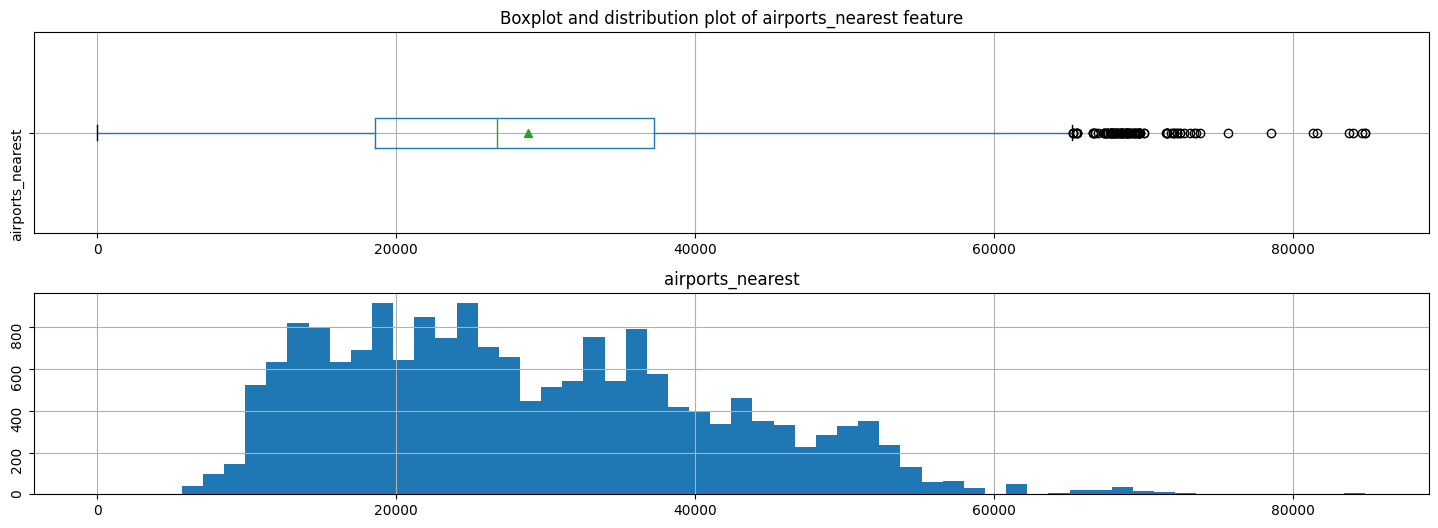

In [94]:
quant_dist(realty, 'airports_nearest')

Как видим, расстояние варьируется от 8 до 90 км. Эти данные принципиальных подозрений не вызывают.

Сложность в другом: как заполнить пропуски? Один из путей таков: попробовать найти объявления из этого же населенного пункта, в которых расстояние до аэропорта указано. Если таковые есть - заполнить пропуски будет несложно.

Для поиска таких наблюдений напишем небольшой цикл. Он подсчитывает для каждого названия населенного пункта:
* количество записей, в которых есть значение расстояний до аэропрота;
* количество записей, в которых это значение пропущено.

Если эти количества отличаются друг от друга либо совпадают, но записей с расстоянием до аэропорта больше нуля - цикл выводит и название населенного пункта, и оба значения.

In [95]:
for locality in locality_list:
    no_airport = realty[(realty['locality_name'] == locality) & (realty['airports_nearest'].isna() == True)]['airports_nearest'].count()
    has_airport = realty[(realty['locality_name'] == locality) & (realty['airports_nearest'].isna() == False)]['airports_nearest'].count()
    if no_airport != has_airport or has_airport != 0:
        print(f"Для {locality} записей без аэропорта - {no_airport}, с аэропортом - {has_airport}")


Для санкт-петербург записей без аэропорта - 0, с аэропортом - 15636
Для ломоносов записей без аэропорта - 0, с аэропортом - 132
Для петергоф записей без аэропорта - 0, с аэропортом - 201
Для пушкин записей без аэропорта - 0, с аэропортом - 369
Для колпино записей без аэропорта - 0, с аэропортом - 337
Для кронштадт записей без аэропорта - 0, с аэропортом - 95
Для павловск записей без аэропорта - 0, с аэропортом - 38
Для сестрорецк записей без аэропорта - 0, с аэропортом - 183
Для зеленогорск записей без аэропорта - 0, с аэропортом - 24
Для unknown записей без аэропорта - 0, с аэропортом - 41


Таких записей мы не нашли. Это означает, что у нас нет возможности на основании данных из датасета определить расстояние до аэропорта и заполнить им пропуски. Медианное или среднее значение, очевидно, не сработает для таких географических данных. Придется оставить пропуски в покое.

In [96]:
del no_airport, has_airport

### `'city_centers_nearest'` — distance to a settlement center (meters)

Feature: city_centers_nearest
count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64


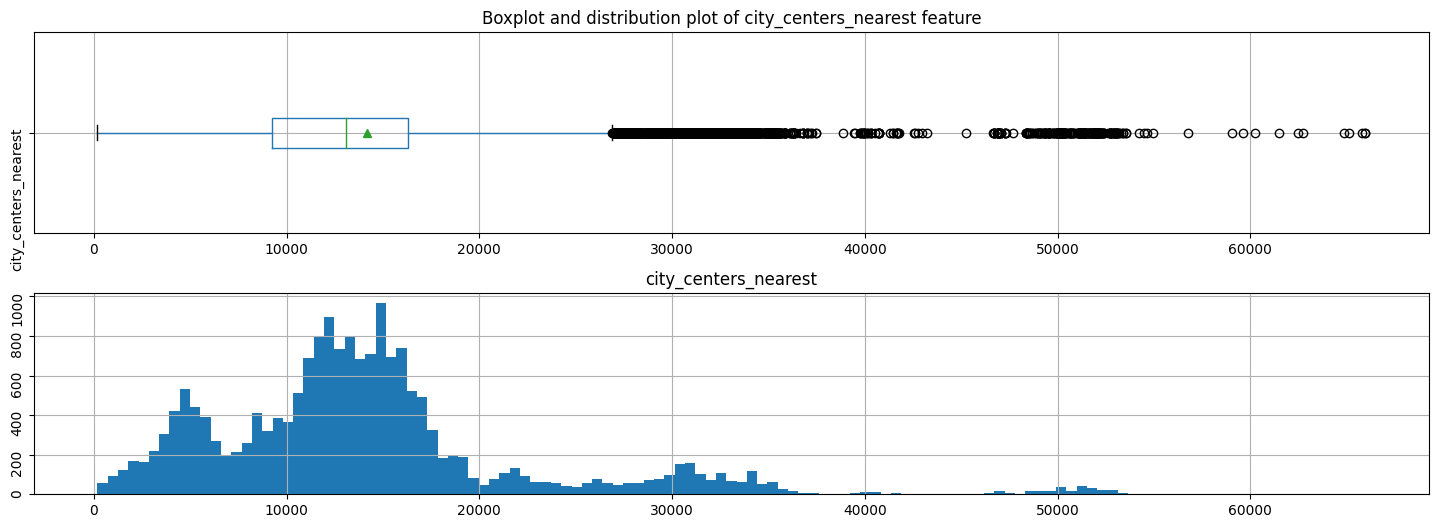

In [97]:
quant_dist(realty, 'city_centers_nearest')

Пока в данных не заметно особых проблем. Отдельные "пики" на графиках могут соответствовать объявлениям об объектах недвижимости, объединненных населенным пунктом. При этом нам известно, что в данных есть пропуски. По аналогии с предыдущим пунктом можно предположить, что пропуски будут встречаться в данных, для которых по каким-либо причинам было сложно автоматически вычислить расстояние для центра города. Применим к ним ту же логику, что и к расстоянию до аэропорта: посмотрим, есть ли у нас возможность заполнить хотя бы некоторые пропуски на основе данных из других объявлений, относящихся к тому же населенному пункту с указанным расстоянием до центра Санкт-Петербурга:

In [98]:
for locality in locality_list:
    no_city_center = realty[(realty['locality_name'] == locality) & (realty['city_centers_nearest'].isna() == True)]['city_centers_nearest'].count()
    has_city_center = realty[(realty['locality_name'] == locality) & (realty['city_centers_nearest'].isna() == False)]['city_centers_nearest'].count()
    if no_city_center != has_city_center or has_city_center != 0:
        print(f"Для {locality} записей без расстояния до центра - {no_city_center}, с расстоянием до центра - {has_city_center}")


Для санкт-петербург записей без расстояния до центра - 0, с расстоянием до центра - 15660
Для ломоносов записей без расстояния до центра - 0, с расстоянием до центра - 132
Для петергоф записей без расстояния до центра - 0, с расстоянием до центра - 201
Для пушкин записей без расстояния до центра - 0, с расстоянием до центра - 368
Для колпино записей без расстояния до центра - 0, с расстоянием до центра - 337
Для кронштадт записей без расстояния до центра - 0, с расстоянием до центра - 95
Для павловск записей без расстояния до центра - 0, с расстоянием до центра - 38
Для сестрорецк записей без расстояния до центра - 0, с расстоянием до центра - 183
Для зеленогорск записей без расстояния до центра - 0, с расстоянием до центра - 24
Для unknown записей без расстояния до центра - 0, с расстоянием до центра - 41


Тот же вывод, что и для аэропорта. К сожалению, у нас нет возможности на основании данных из датасета определить расстояние до центра и заполнить им пропуски. Медианное или среднее значение здесь неприемлемо. Оставим пропуски без изменений.

In [99]:
del locality, locality_list, no_city_center, has_city_center

### `'parks_around_3000'` — how many parks are within 3 kilometers distance

Feature: parks_around_3000
count    18181.000000
mean         0.611408
std          0.802074
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around_3000, dtype: float64


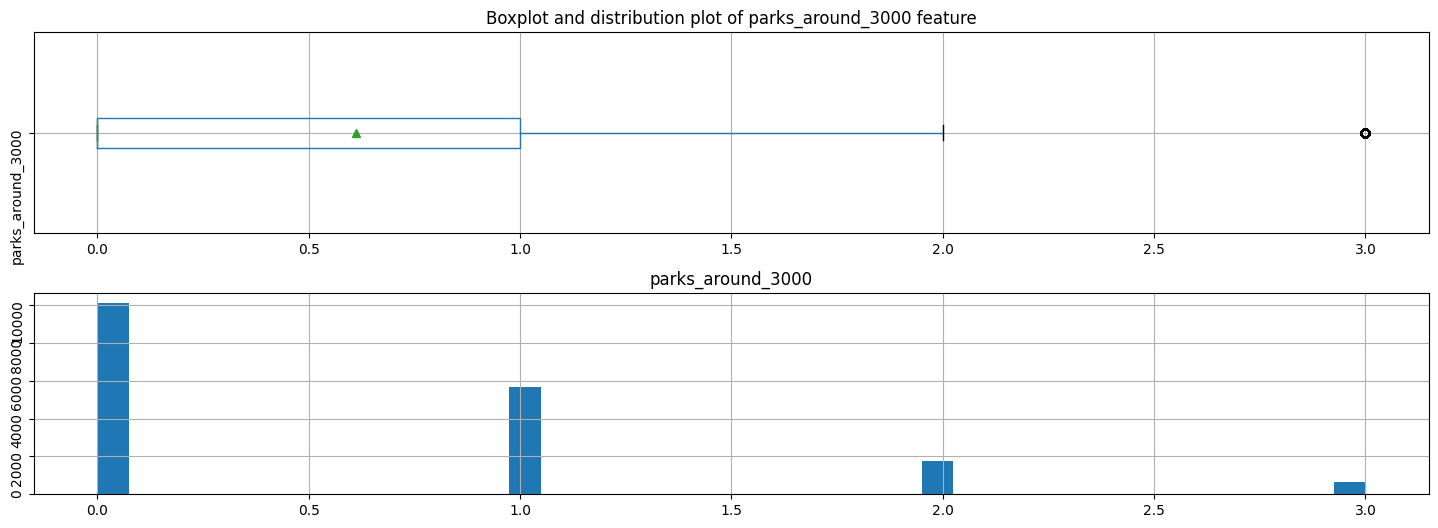

In [100]:
quant_dist(realty, 'parks_around_3000')

Довольно ожидаемое распределение. Далеко не каждый объект недвижимости может похвастаться парком, а то и несколькими в пределах пешей доступности. Тут же можно сделать предположение: отсутствие значения в этом столбце можно интерпретировать как 0 парков в пределах радиуса 3 км. Заполним пропуски этим значением: 

In [101]:
realty.loc[:, 'parks_around_3000'] = realty.loc[:, 'parks_around_3000'].fillna(0).astype('int8')

/var/folders/z9/nxf9mlds6rlgnch0_jb60f800000gn/T/ipykernel_56267/3522174915.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  realty.loc[:, 'parks_around_3000'] = realty.loc[:, 'parks_around_3000'].fillna(0).astype('int8')


### `'parks_nearest'` — distance to a nearest park (meters)

Feature: parks_nearest
count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


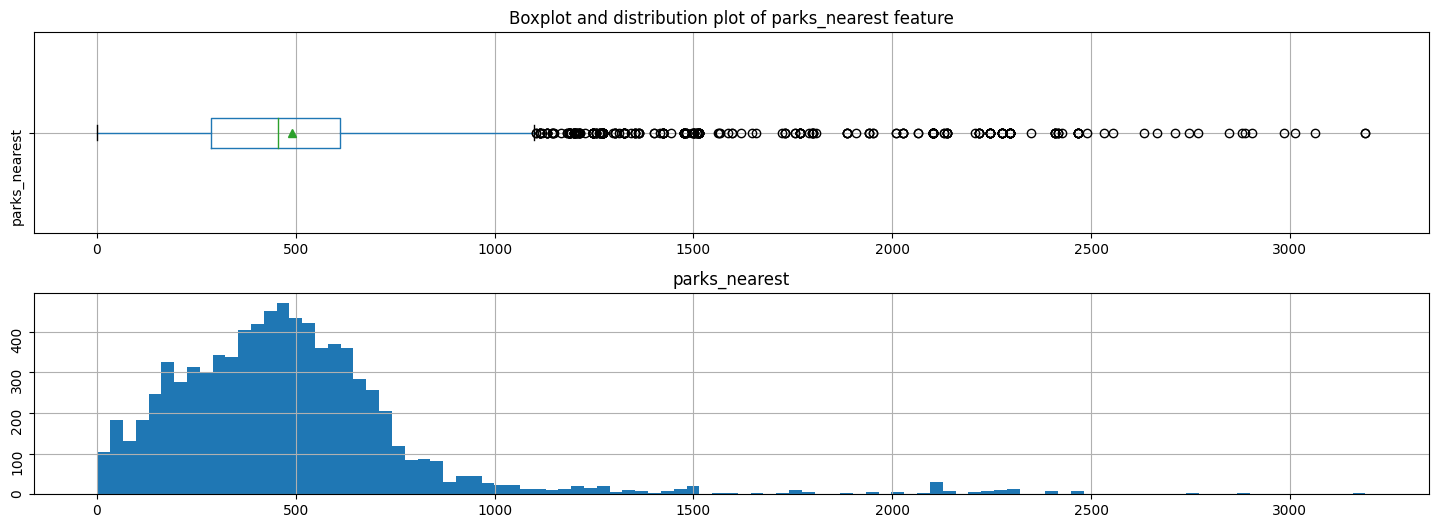

In [102]:
quant_dist(realty, 'parks_nearest')

Как здорово иметь поблизости парк! Тем более здорово знать, что в большей части объявлений, упоминающих парк, он находится так близко. Позже посмотрим, влияет ли это на цену

### `'ponds_around_3000'` — how many ponds or lakes are within 3 kilometers distance

Feature: ponds_around_3000
count    18181.000000
mean         0.770255
std          0.938346
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around_3000, dtype: float64


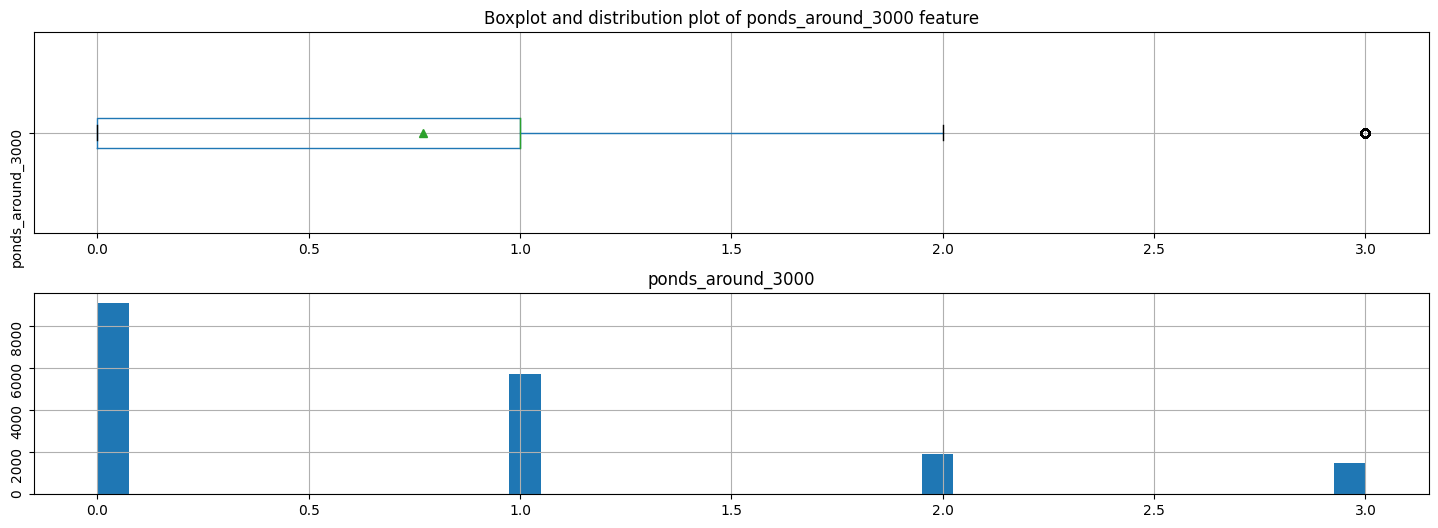

In [103]:
quant_dist(realty, 'ponds_around_3000')

Тоже ничего необычного. К сожалению, прудов не так много, и не каждое объявление может похвастать прудом неподалеку. Так же, как и с парками, предположим, что пропуск означает отсутствие пруда поблизости (пользователи просто решили не заполнять это поле):

In [104]:
realty.loc[:, 'ponds_around_3000'] = realty.loc[:, 'ponds_around_3000'].fillna(0).astype('int8')

/var/folders/z9/nxf9mlds6rlgnch0_jb60f800000gn/T/ipykernel_56267/4005227038.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  realty.loc[:, 'ponds_around_3000'] = realty.loc[:, 'ponds_around_3000'].fillna(0).astype('int8')


### `'ponds_nearest'` — distance to a nearest pond or lake (meters)

Feature: ponds_nearest
count    9110.000000
mean      517.980900
std       277.720643
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64


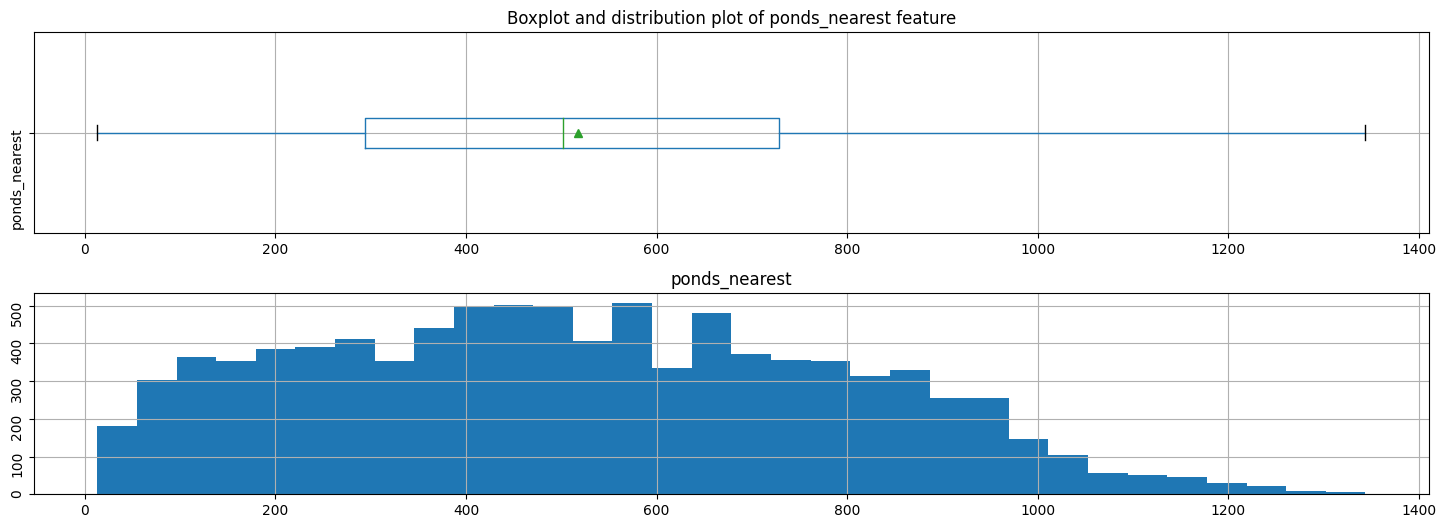

In [105]:
quant_dist(realty, 'ponds_nearest')

Опять же, отличное, очень равномерное распределение. Если уж довелось иметь пруд в радиусе 3 километров, - на самом деле он будет не дальше полутора километров, то есть примерно 20-минутной прогулки.

### `'days_exposition'` — how long an ad stayed from publication to taking out (days)

Feature: days_exposition
count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


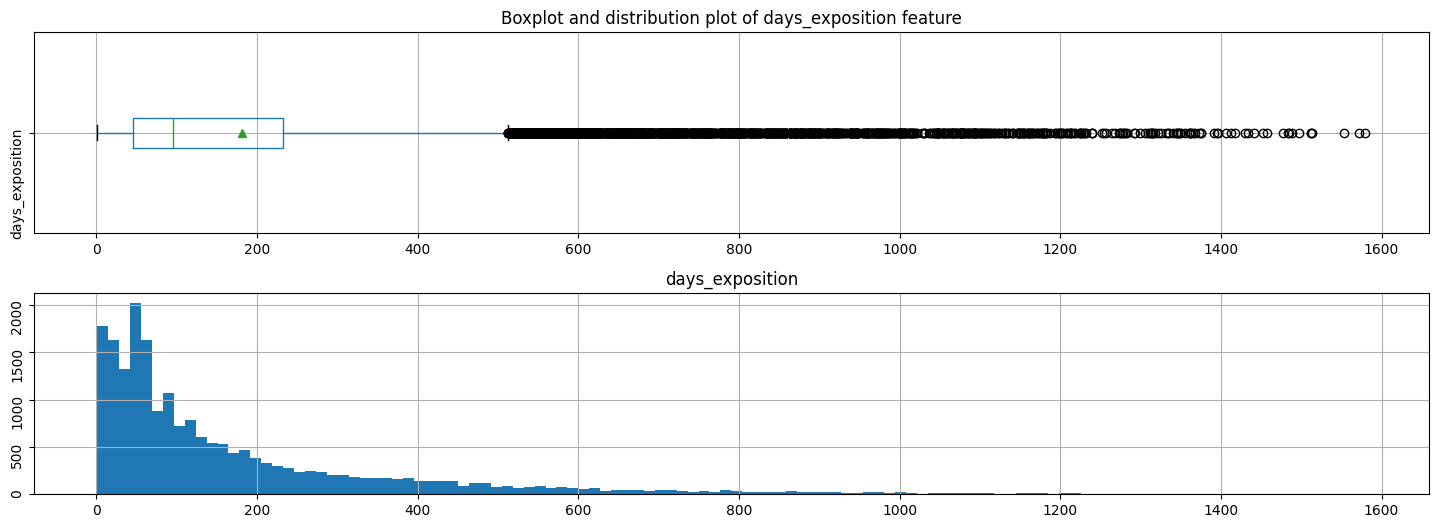

In [106]:
quant_dist(realty, 'days_exposition')

Плохие новости для пользователей, надеющихся, что Яндекс.Недвижимость позволит продать объект за пару недель. Хорошие новости для более реалистично настроенных пользователей в том, что половина всех объектов снимается с продажи (будем надеятся, по причине успешной сделки) за 3 месяца, а три четверти всех объектов - за 7-8 месяцев.

Судя по этим данным, "быстрая продажа квартиры" - это до полутора месяца (нижняя граница второго квартиля). Иными словами, если вы собарлись продавать квартиру в Санкт-Петербурге и окрестностях - запаситесь временем от квартала до полугода, у вас есть 2 шанса из трех продать её за это время.

И не забудем о продажах, которые занимают более года, особенно о рекордсменах от двух лет и выше, включая главного рекордсмена - объект, продававшийся почти 5 лет.

Кроме того, у нас есть несколько пропусков, которые предлагается заполнить медианными значениями:

In [107]:
realty.loc[:, 'days_exposition'] = realty.loc[:, 'days_exposition'].fillna(
    realty['days_exposition'].describe()['50%']).astype('int16')

/var/folders/z9/nxf9mlds6rlgnch0_jb60f800000gn/T/ipykernel_56267/990831062.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  realty.loc[:, 'days_exposition'] = realty.loc[:, 'days_exposition'].fillna(


Посмотрим пристальнее на объявления длительностью до одного года:

<AxesSubplot:>

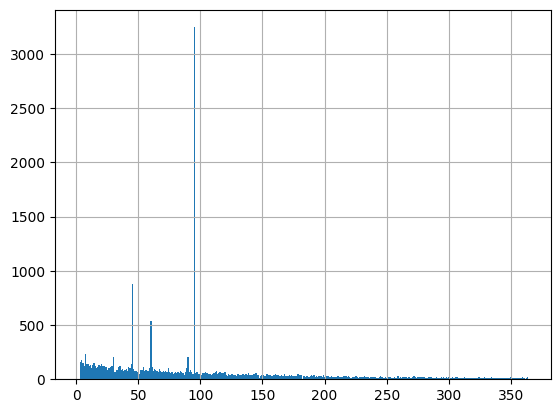

In [108]:
realty.query('days_exposition < 365')['days_exposition'].hist(bins=365)

Бросаются в глаза высокие пики, явно выбивающиеся за пределы общего равномерного распределения. Обратим внимание на все значения количества дней размещения объявлений, которым соответствует более 500 объявлений:

In [109]:
realty.query('days_exposition < 365')['days_exposition'].value_counts().head(10)

95    3245
45     880
60     538
7      234
30     208
90     204
4      176
3      158
5      152
14     148
Name: days_exposition, dtype: int64

Основные пики количества объявлений соответствуют "круглым" значением в 45, 60 и 95 дней. Следующие за ними значения тоже "красивые" - 7, 30 и 90 дней. Такая склонность к округленным значениям точно не входит в число характеристик любого "естестенного" распределения. Можно предположить, что это - следы автоматического либо "ручного" округления значений (либо присвоения отсутствующих значений) на каком-либо этапе формирования датасета или автоматическое снятие объявлений с продления.

### Вывод по предобработке данных

Мы заполнили пропуски данных, где это было возможно, и изменили тип данных в ряде столбцов. Где-то мы делали это, потому что это давало возможность иначе работать с данными (например, для типа "дата-время"), а где-то - в порядек эксперимента, чтобы проверить, позволяет ли это оптимизировать как минимум использование памяти. Время проверить, насколько успешен наш эксперимент:

In [110]:
realty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int8          
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int8          
 5   ceiling_height        23699 non-null  float32       
 6   floors_total          23699 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

"Экономия" составила примерно 1,1 мб, что может в абсолютных показателях показаться небольшим успехом, но в относительных - это почти 30%-ная оптимизация. В высоконагруженных системах с действительно большими объемами данных такая оптимизация может выражаться в гига- и терабайтах "сэкономленного" пространства памяти и часах машинного времени.

## Расчеты и добавление данных в таблицу

Нам необходимо добавить в таблицу столбцы, содержащие:

* цену квадратного метра;
* день недели, месяц и год публикации объявления;
* этаж квартиры; варианты — первый, последний, другой;
* соотношение жилой и общей площади, а также отношение площади кухни к общей.

### Цена квадратного метра

Feature: square_meters
count    2.369900e+04
mean     9.942637e+04
std      5.030273e+04
min      7.963000e+03
25%      7.659950e+04
50%      9.500000e+04
75%      1.142560e+05
max      1.907500e+06
Name: square_meters, dtype: float64


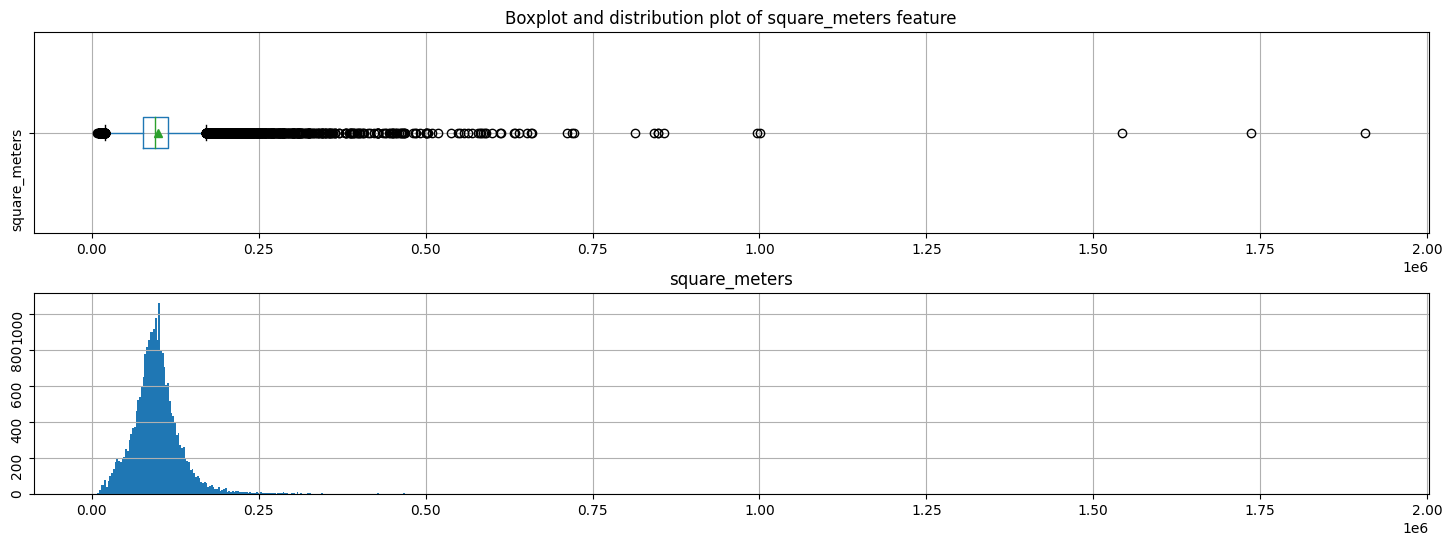

In [111]:
realty['square_meters'] = round(realty['last_price'] / realty['total_area']).astype('int32')
quant_dist(realty, 'square_meters')

Из-за выбросов картина очень непонятна. Отфильтруем их, задав верхнюю границу стоимости в 250 тыс.руб за м²:

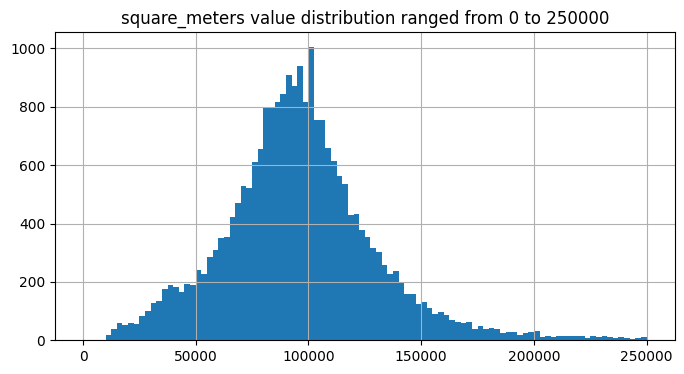

count    2.369900e+04
mean     9.942637e+04
std      5.030273e+04
min      7.963000e+03
25%      7.659950e+04
50%      9.500000e+04
75%      1.142560e+05
max      1.907500e+06
Name: square_meters, dtype: float64

In [112]:
details(realty['square_meters'], 250000)

Что же, вполне понятное распределение стоимости. Особых вопросов оно не вызывает. А вот выбросы вроде более миллиона рублей за квадратный метр вызывают интерес:

In [113]:
realty[realty['square_meters'] > 1000000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,square_meters
1436,19,330000000,190.0,2018-04-04,3,3.50,7.0,95.0,5,False,...,0,санкт-петербург,23011.0,1197.0,3,519.0,3,285.0,233,1736842
12971,19,763000000,400.0,2017-09-30,7,2.65,10.0,250.0,10,False,...,2,санкт-петербург,25108.0,3956.0,1,530.0,3,756.0,33,1907500
14706,15,401300000,401.0,2016-02-20,5,2.65,9.0,204.0,9,False,...,3,санкт-петербург,21912.0,2389.0,1,545.0,1,478.0,393,1000748
22831,18,289238400,187.5,2019-03-19,2,3.37,6.0,63.7,6,False,...,0,санкт-петербург,22494.0,1073.0,3,386.0,3,188.0,95,1542605


Однако никаких особых сюрпризов здесь нет. Просто ЧУДОВИЩНО переоцененная недвижимость, - или ошибка на ноль-другой при заполнени объявления.

### День, месяц, год публикации объявления

In [114]:
realty.loc[:, 'day_exposition'] = pd.DatetimeIndex(realty.loc[:, 'first_day_exposition']).weekday
realty.loc[:, 'month_exposition'] = pd.DatetimeIndex(realty.loc[:, 'first_day_exposition']).month
realty.loc[:, 'year_exposition'] = pd.DatetimeIndex(realty.loc[:, 'first_day_exposition']).year

In [115]:
def exposition_day(column):
    '''
    The function processes a date and provides its details.
    It takes the only argument:
    1. column: a dataframe column containing dates in the following
       format: realty.loc[row, 'column']
    
    The function returns day of week as string.
    '''
    days = {0: '0 - Monday', 1: '1 - Tuesday', 2: '2 - Wednesday',
            3: '3 - Thursday', 4: '4 - Friday', 5: '5 - Saturday', 6: '6 - Sunday'}
    return days[column]

In [116]:
def exposition_month(column):
    '''
    The function processes a date and provides its details.
    It takes the only argument:
    1. column: a dataframe column containing dates in the following
       format: realty.loc[row, 'column']
    
    The function returns month as string.
    '''
    months = {1: '00 - January', 2: '01 - February', 3: '02 - March', 4: '03 - April',
              5: '04 - May', 6: '05 - June', 7: '06 - July', 8: '07 - August', 
              9: '08 - September', 10: '09 - October', 11: '10 - November', 12: '11 - December'}
    return months[column]

In [117]:
realty.loc[:, 'day_exposition'] = realty.loc[:, 'day_exposition'].apply(exposition_day)
realty.loc[:, 'month_exposition'] = realty.loc[:, 'month_exposition'].apply(exposition_month)

Проверим результат:

In [118]:
print(realty['day_exposition'].value_counts())
print()
print(realty['month_exposition'].value_counts())

3 - Thursday     4295
1 - Tuesday      4183
4 - Friday       4000
2 - Wednesday    3974
0 - Monday       3612
5 - Saturday     1936
6 - Sunday       1699
Name: day_exposition, dtype: int64

01 - February     2640
02 - March        2587
03 - April        2379
10 - November     2371
09 - October      2127
08 - September    1981
05 - June         1760
07 - August       1744
06 - July         1695
11 - December     1641
00 - January      1500
04 - May          1274
Name: month_exposition, dtype: int64


Номера в названиях дней и месяцев - для их выстраивания в графиках в том же порядке, в каком они следуют в неделе и в году.

### Этаж квартиры

Здесь потребуется категоризация:

In [119]:
def floor_category(row):
    '''
    The function catogorizes observations based on a 'floor' column value.
    It takes the only argument:
    1. row: a dataframe row containing dates in the following
       format: realty.loc[row, 'column']

    The function returns one categorical value from the list:
    - 'Top floor'
    - 'Ground floor'
    - 'Other floor'
    '''
    if row['floor'] == row['floors_total']:
        return 'Top floor'
    elif row['floor'] == 1:
        return 'Ground floor'
    return 'Other floor'

In [120]:
realty.loc[:, 'floor_category'] = realty.loc[:].apply(floor_category, axis=1)
realty['floor_category'].value_counts()

Other floor     17404
Top floor        3403
Ground floor     2892
Name: floor_category, dtype: int64

### Соотношение разных типов площади

Вернемся ко вспомогательному датафрейму `'area'`. Добавим в него еще один столбец, а затем перенесем оба столбца в основной датафрейм:

In [121]:
area['living_to_total_ratio'] = round((area['living_area'] / area['total_area']), 2)
realty[['living_to_total_ratio', 'kitchen_to_total_ratio']] = area[['living_to_total_ratio', 'kitchen_to_total_ratio']]

Наконец, удалим вспомогательный датафрейм, который мы создавали раньше. Он славно нам послужил, и теперь его дозор окончен ⚔

In [122]:
del area

## Исследовательский анализ данных

### Связи между переменными

Проверим, присутствуют ли линейные и нелинейные связи между категориальными и количественными переменными (автоматически приведенными к интервальному виду). Для этого сначала проверим типы данных датасета в его нынешнем виде:

In [123]:
realty.dtypes

total_images                        int8
last_price                         int32
total_area                       float64
first_day_exposition      datetime64[ns]
rooms                               int8
ceiling_height                   float32
floors_total                     float64
living_area                      float64
floor                              int64
is_apartment                        bool
studio                              bool
open_plan                           bool
kitchen_area                     float64
balcony                            int32
locality_name                     object
airports_nearest                 float64
city_centers_nearest             float64
parks_around_3000                   int8
parks_nearest                    float64
ponds_around_3000                   int8
ponds_nearest                    float64
days_exposition                    int16
square_meters                      int32
day_exposition                    object
month_exposition

Используем расширенный тип данных pandas для категориальных переменных:

In [124]:
for col in ['locality_name', 'day_exposition', 'month_exposition', 'floor_category']:
    realty[col] = pd.Categorical(realty[col])

Выведем корреляционную матрицу сразу в виде тепловой карты:

/Users/idrv/opt/anaconda3/envs/Practicum/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable first_day_exposition is large: 1491. Are you sure this is not an interval variable? Analysis for pairs of variables including first_day_exposition can be slow.
  warnings.warn(


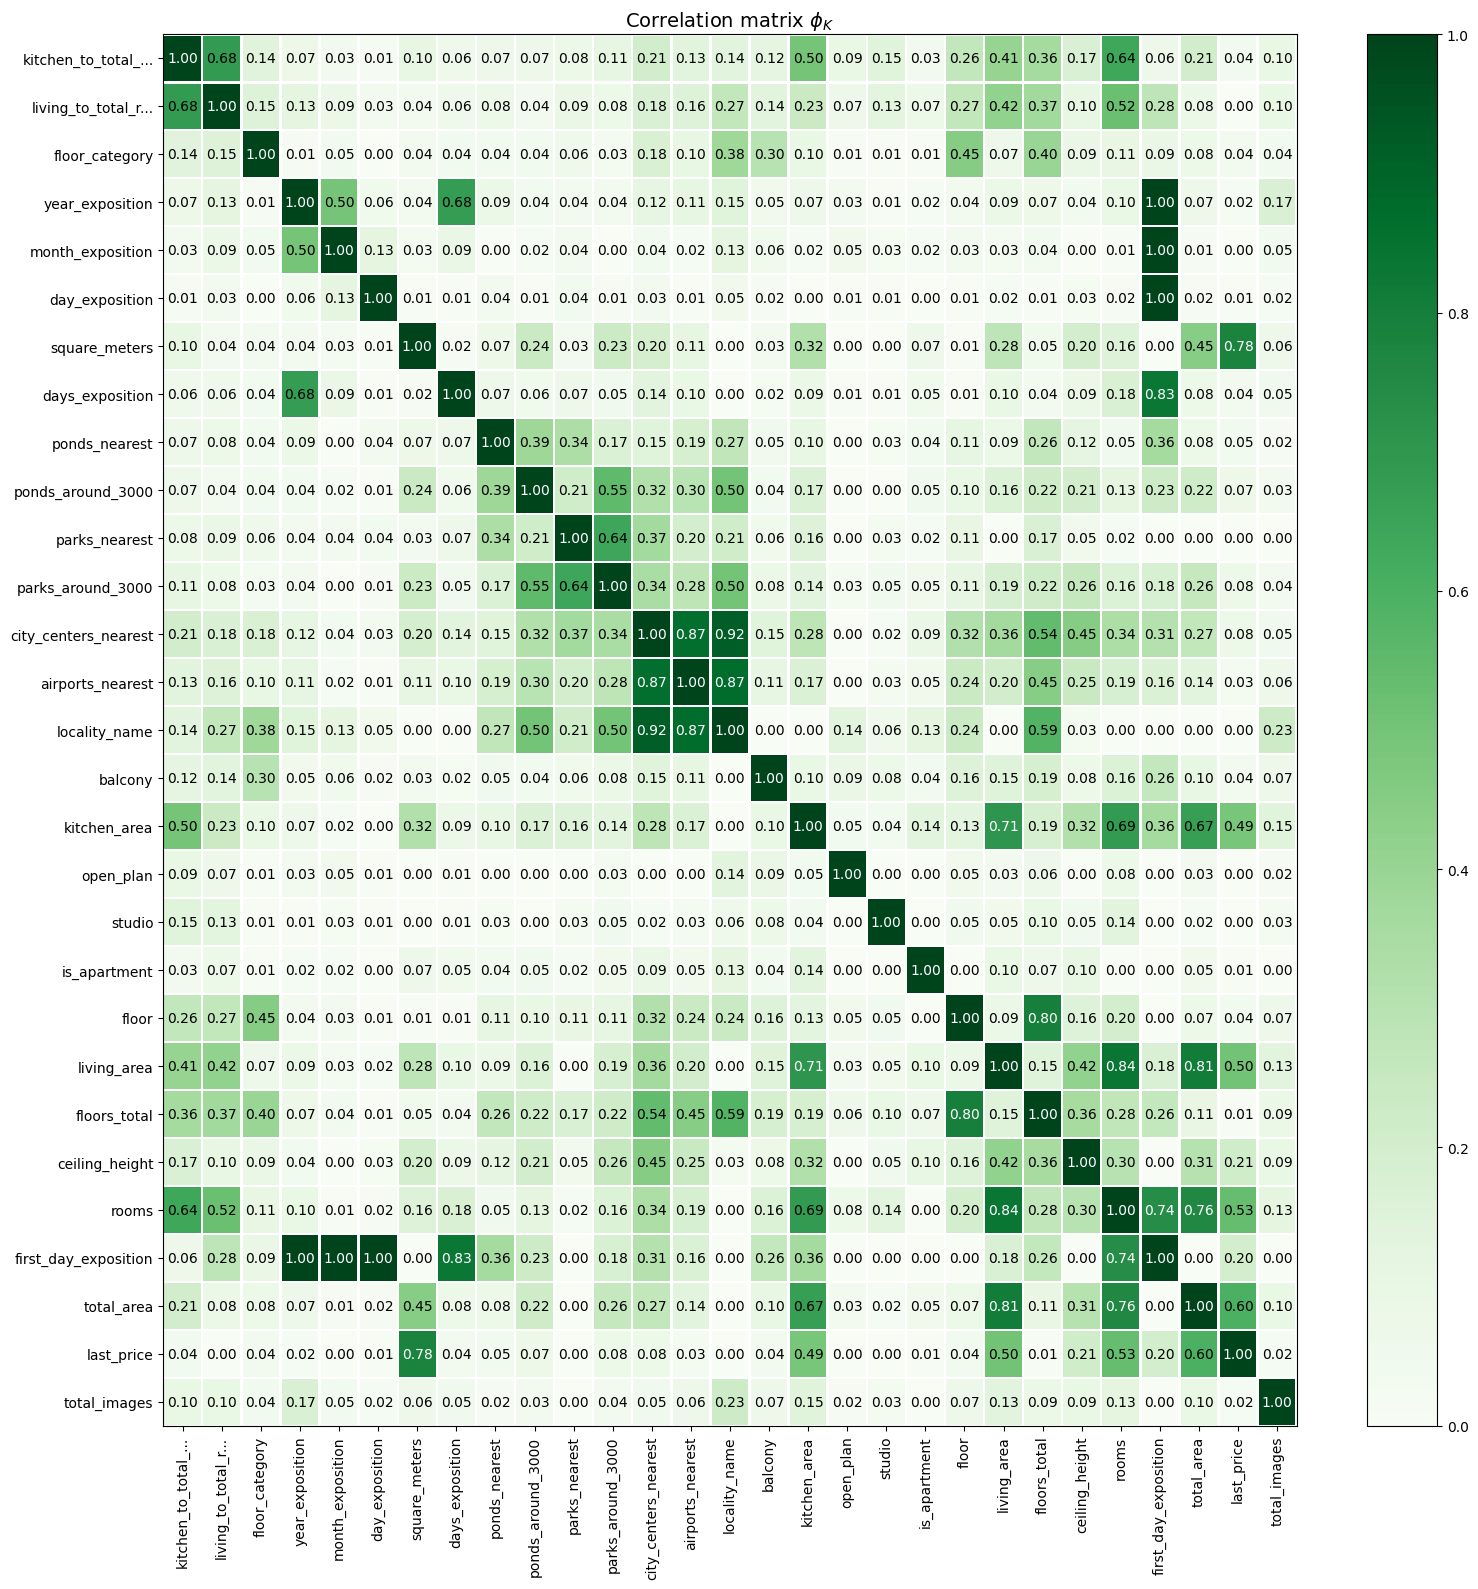

In [125]:
collinearity = realty.phik_matrix(interval_cols=['total_images', 'last_price', 'total_area',
                                                 'rooms', 'ceiling_height', 'floors_total',
                                                 'living_area', 'floor', 'kitchen_area', 'balcony',
                                                 'airports_nearest', 'city_centers_nearest', 'parks_around_3000',
                                                 'parks_nearest', 'ponds_around_3000', 'ponds_nearest',
                                                 'days_exposition', 'square_meters', 'year_exposition',
                                                 'living_to_total_ratio', 'kitchen_to_total_ratio'])
plot_correlation_matrix(collinearity.values, 
                        x_labels=collinearity.columns, 
                        y_labels=collinearity.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Correlation matrix $\phi_K$",
                        figsize=(16, 16))
plt.tight_layout()

Из-за большого количества признаков в матрице остановимся только на признаках, демонстрирующих коэффициенты корреляции более 0.55 (среднее значение для "заметной" корреляции по шкале Чеддока).



In [126]:
collinearity = realty[['kitchen_to_total_ratio', 'living_to_total_ratio', 'year_exposition',
                       'month_exposition', 'day_exposition', 'square_meters', 'days_exposition',
                       'parks_nearest', 'parks_around_3000', 'ponds_around_3000', 'ponds_nearest',
                       'city_centers_nearest', 'airports_nearest', 'kitchen_area', 'floor', 'living_area',
                       'floors_total', 'rooms', 'first_day_exposition', 'total_area', 'last_price']].phik_matrix(
                           interval_cols=['last_price', 'total_area', 'rooms', 'floors_total',
                                          'living_area', 'floor', 'kitchen_area', 'airports_nearest',
                                          'city_centers_nearest', 'parks_around_3000', 'parks_nearest',
                                          'ponds_around_3000', 'ponds_nearest', 'days_exposition',
                                          'square_meters', 'living_to_total_ratio', 'kitchen_to_total_ratio'])

/Users/idrv/opt/anaconda3/envs/Practicum/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable first_day_exposition is large: 1491. Are you sure this is not an interval variable? Analysis for pairs of variables including first_day_exposition can be slow.
  warnings.warn(


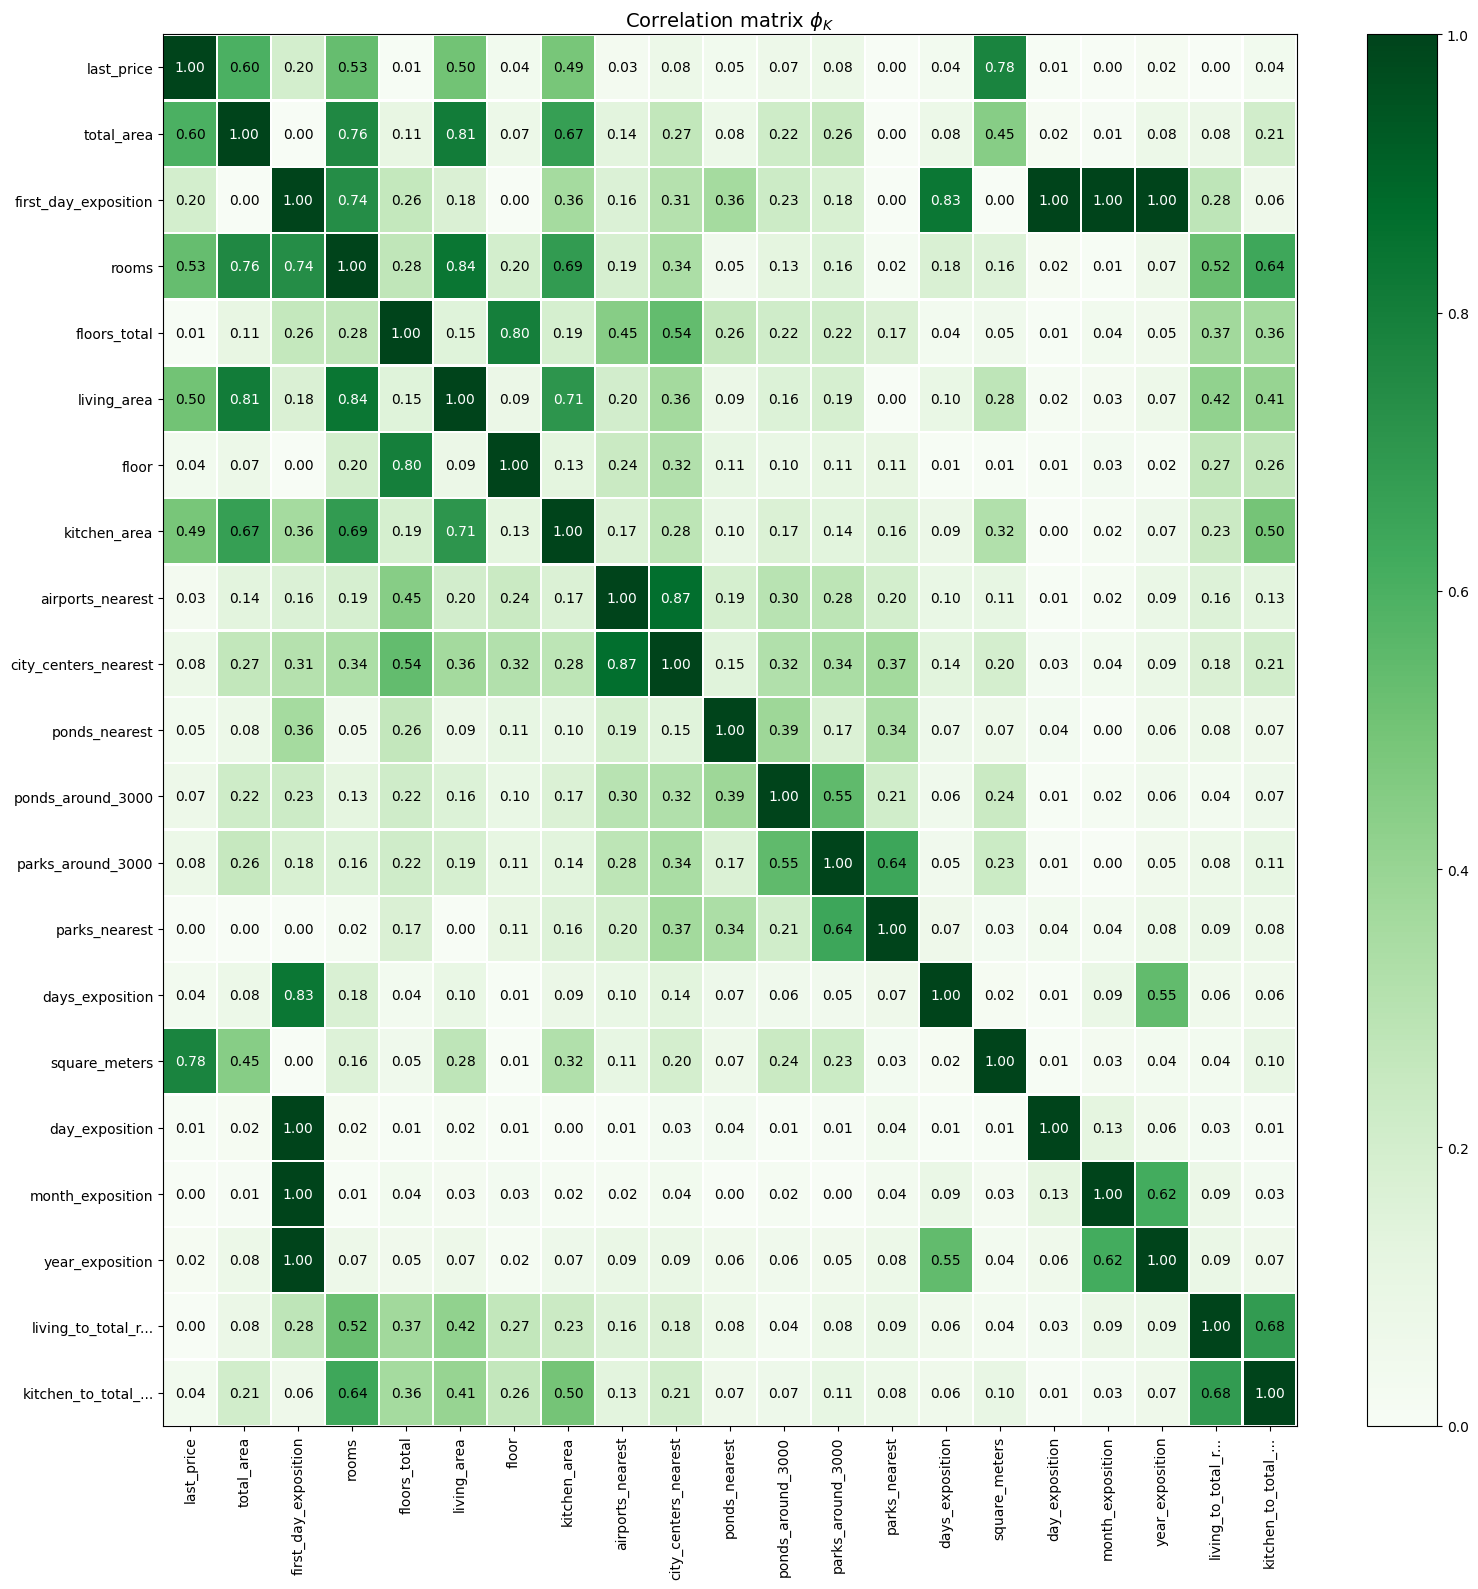

In [127]:
plot_correlation_matrix(collinearity.values, 
                        x_labels=collinearity.columns, 
                        y_labels=collinearity.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Correlation matrix $\phi_K$",
                        figsize=(16, 16))
plt.tight_layout()

Ожидаема (и совсем неудивительна) довольно тесная связь отдельных параметров, так или иначе описывающих квадратуру объекта недвижимости: общей площади, количества комнат, площади жилых комнат, кухни, соотношения площадей кухни и жилых комнат к общей площади (последние два признака - синтетические, созданы ранее для устранения ошибок и пропусков в данных). Если бы мы разрабатывали прогнозную модель недвижимости, большую часть этих признаков не следовало бы в неё включать.

Кроме соотношения площадей, в датасете присутствуют еще несколько производных друг от друга признаков, чем объясняется высокий коэффициент корреляции между ними:
- Дата размещения объявления и длительность демонстрации объявления;
- Дата размещения объявления и год, месяц, день недели, когда объявление было размещено;
- Длительность демонстрации объявления и день недели, когда объявление было размещено;
- Год публикации объявления и месяц публикации объявления.

Обнаружена связь между признаками, не являющимися прямыми производными друг от друга:
- Количество парков поблизости и расстояние до ближайшего парка. Довольно ожидаемо - эти переменные немного по-разному описывают одно явление "рядом с объектом есть парк".
- Количество парков поблизости и количество прудов поблизости. Вероятность встретить пруд в парке гораздо выше вероятности встретить пруд за его пределами.
- расстояние до центра города и расстояние до аэропорта. Эта связь может быть обратной (коэффициент фита не дает сведений о направлении связи). Проверим с помощью коэффициента линейной корреляции:

In [128]:
realty[['airports_nearest', 'city_centers_nearest']].corr()

,airports_nearest,city_centers_nearest
airports_nearest,1.000000,0.272184
city_centers_nearest,0.272184,1.000000


Линейная связь слабая. Видимо, эти переменные связаны нелинейно: чем ближе объект к центру Санкт-Петербурга, тем дальше он от аэропорта. Если же речь идет о малых населенных пунктах, то расстояния от объектов до центра, например, Пушкина, могут демонстрировать сильную обратную связь с расстоянием до аэропорта Пулково. Коэффициент фита способен выявлять такие сложные связи.

Наконец, ключевой вывод:
существует умеренно сильная связь между площадью квартиры и ее ценой. Конечно, на цену будут влиять и другие факторы (как минимум расположение, тип недвижимости, транспортная доступность и т.п.). Однако размеры жилплощади остаются тем основанием, на котором строится ценность квартиры, выраженная в денежном эквиваленте.

А вот близость к центру города таковым не является. И это вполне очевидно. Исторические центры городов (особенно - в Санкт-Петербурге) часто застроены объектами, которые не вполне отвечают современным стандартам комфорта, инфраструктурной и коммуникационной обеспеченности.  

<AxesSubplot:xlabel='floor_category'>

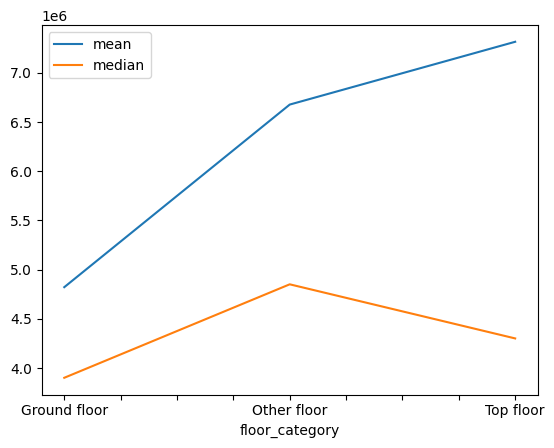

In [129]:
realty.pivot_table(index='floor_category', values='last_price', aggfunc=('mean', 'median')).plot()

Можно точно сказать, что первый этаж лидером по стоимости недвижимости не является. И несмотря на то, что самое дорогой объект недвижимости расположен на последнем этаже, основная доля объектов "подороже" (судя по соотношению медианы и среднего) - в категории "другой этаж".

Наконец, посмотрим на динамику стоимости недвижимости в зависимости от даты размещения, месяца и дня недели.

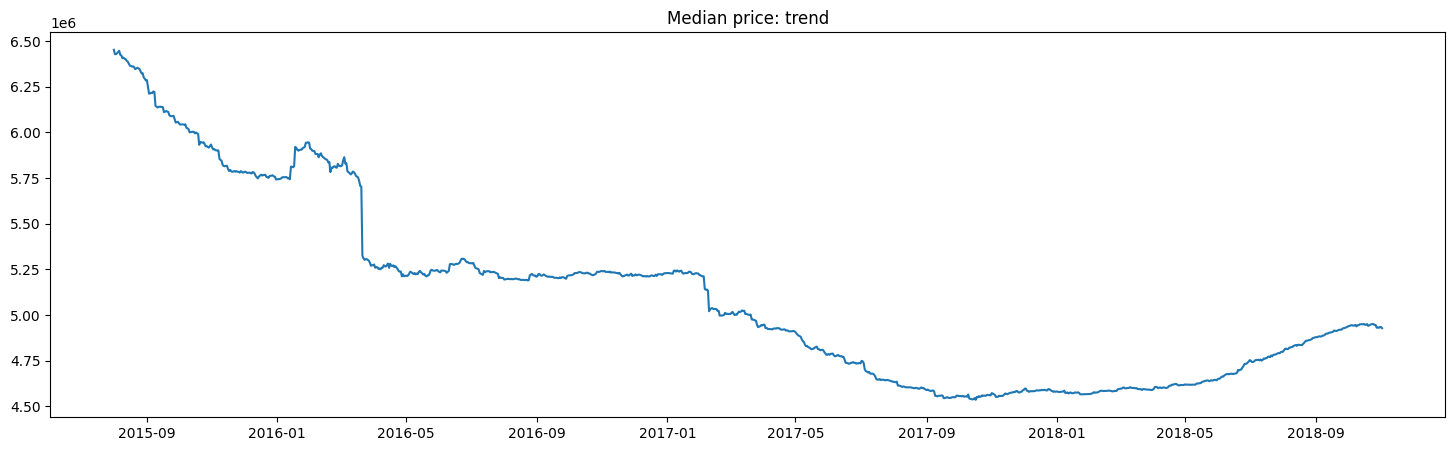

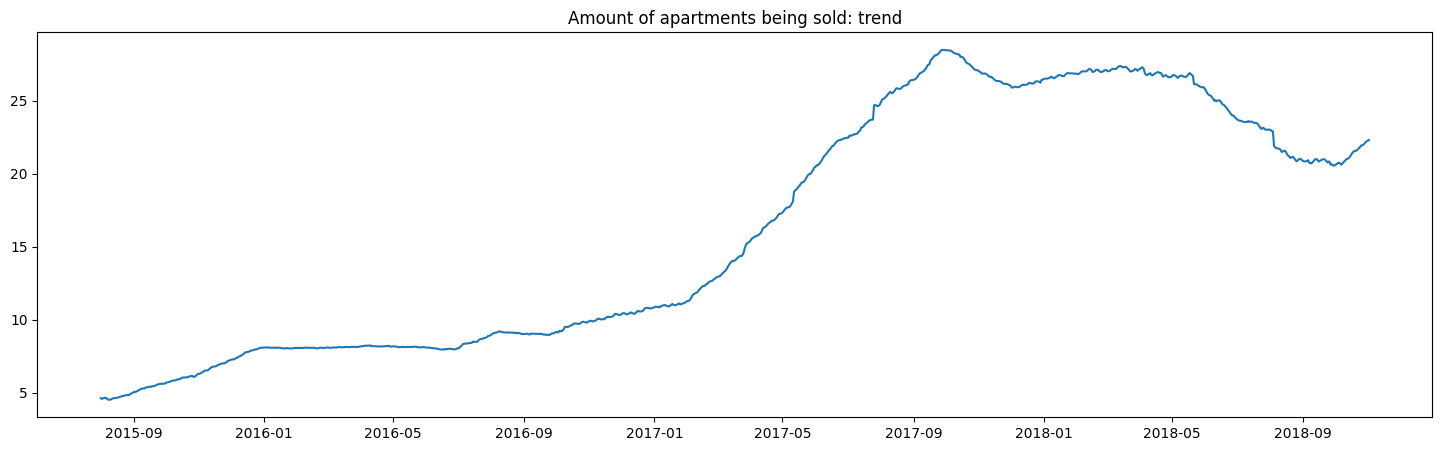

In [130]:
decomp_median = seasonal_decompose(
    realty.pivot_table(index='first_day_exposition',
                   values='last_price', aggfunc='median'),
    period=365)

decomp_count = seasonal_decompose(
    realty.pivot_table(index='first_day_exposition',
                   values='last_price', aggfunc='count'),
    period=365)

plt.figure(figsize=(18, 5))
plt.plot(decomp_median.trend)
plt.title('Median price: trend')
plt.show()

plt.figure(figsize=(18, 5))
plt.plot(decomp_count.trend)
plt.title('Amount of apartments being sold: trend')
plt.show()

Наиболее "урожайными" на продажу недвижимости были 2017-2018 гг. В 2017-м же на продажу был выставлен наиболее дорогой объект. При этом медианное значение стоимости оставалось не слишком высоким, что дает основания полагать: наибольшее количество объявлений касалось жилья "среднего" (или даже "эконом"-) класса.

Графики трендов за весь период наблюдений демонстрируют действие закона спроса и предложения на рынке недвижимости: рост количества объявлений сопровождается снижением медианной цены на объекты недвижимости.

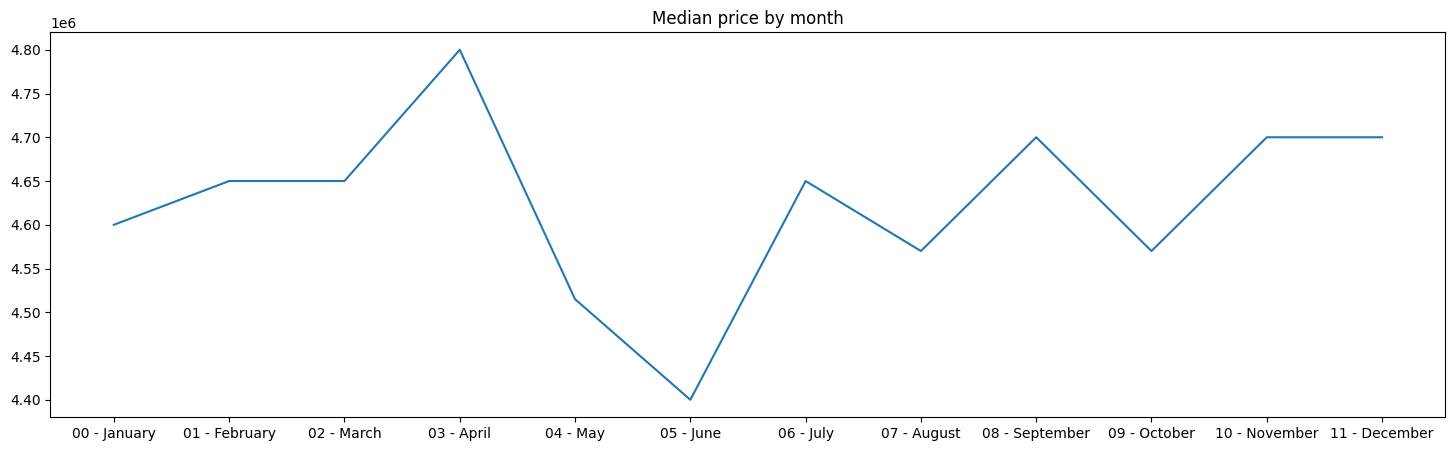

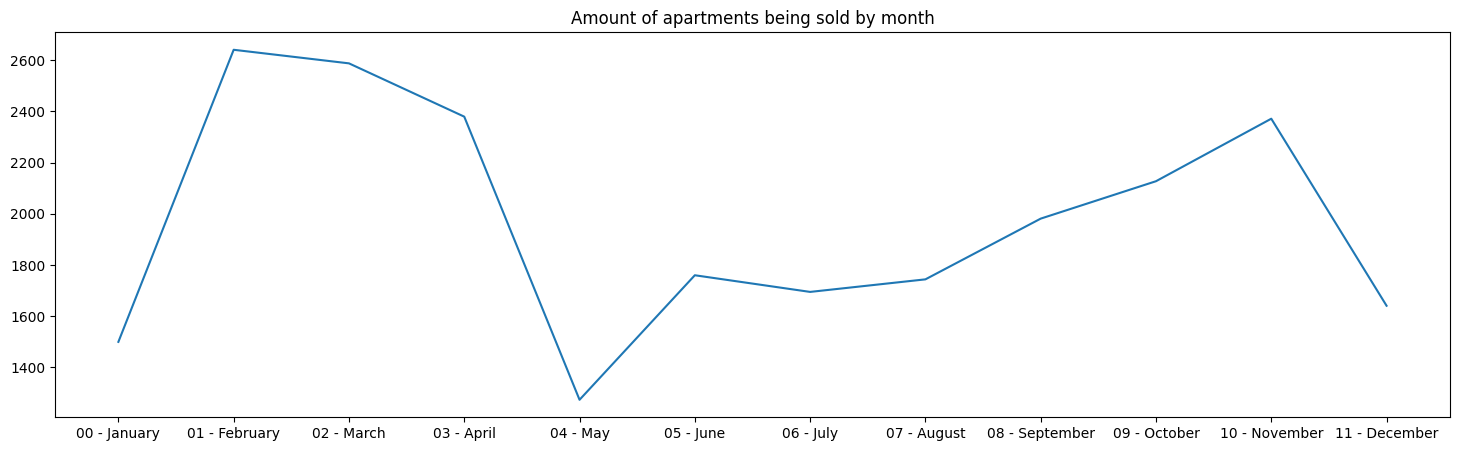

In [131]:
plt.figure(figsize=(18, 5))
plt.plot(realty.pivot_table(index='month_exposition', values='last_price', aggfunc='median'))
plt.title('Median price by month')
plt.show()

plt.figure(figsize=(18, 5))
plt.plot(realty.pivot_table(index='month_exposition', values='last_price', aggfunc='count'))
plt.title('Amount of apartments being sold by month')
plt.show()

Медианная стоимость не слишком колеблется в зависимости от месяца, однако выше всего она в апреле, далее - в сентябре, ноябре и декабре, и далее по нисходящей. Жилье в Санкт-Петербурге точно лучше покупать летом.

Среди месяцев наиболее "популярными" для принятия решения о продаже недвижимости (косвенным признаком которого является размещение соответствующего объявления) являются конец зимы - начало весны (февраль, март, апрель) и ноябрь. В мае покупать недвижимость несколько сложнее: новых предложений на рынке будет мало. 

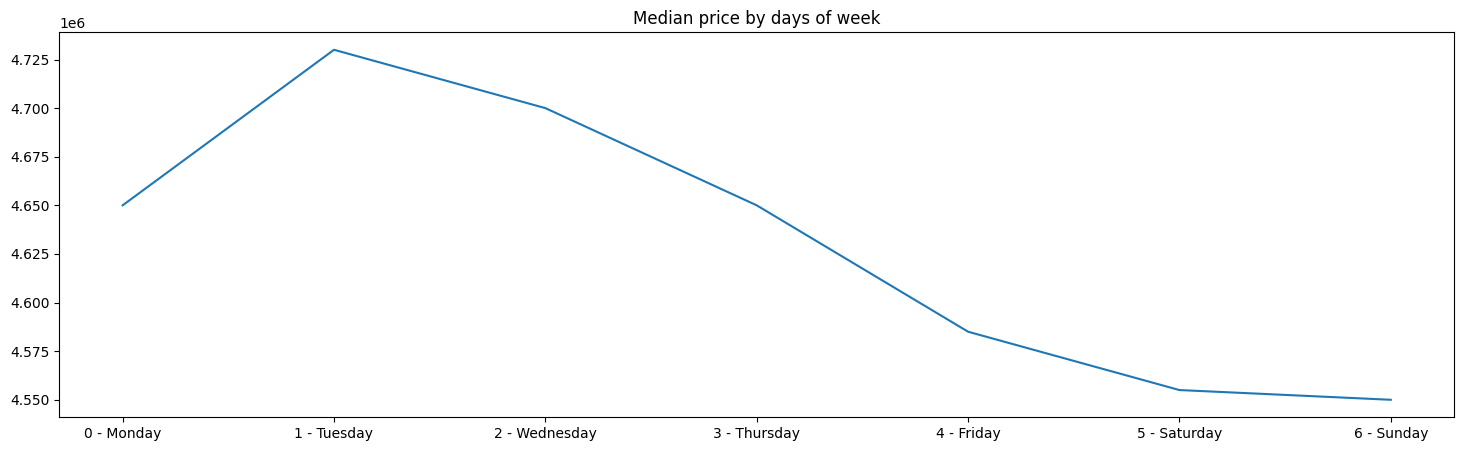

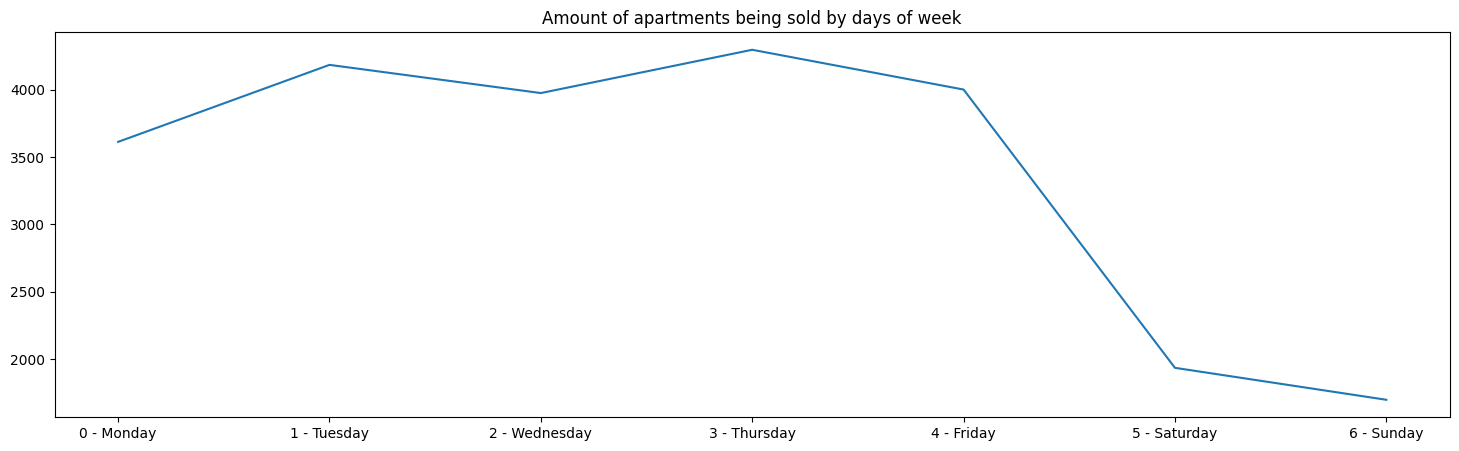

In [132]:
plt.figure(figsize=(18, 5))
plt.plot(realty.pivot_table(index='day_exposition', values='last_price', aggfunc='median'))
plt.title('Median price by days of week')
plt.show()

plt.figure(figsize=(18, 5))
plt.plot(realty.pivot_table(index='day_exposition', values='last_price', aggfunc='count'))
plt.title('Amount of apartments being sold by days of week')
plt.show()

В разрезе дней объявления размещаются чаще в рабочие дни, и гораздо реже - на выходных. А вот медианная стоимость выше для вторников и сред. Первое наблюдение абсолютно ожидаемо, второе - просто забавный и вряд ли объяснимый казус.

In [133]:
del col, collinearity, decomp_count, decomp_median

### Населенные пункты с самым большим количеством объявлений

Отсортируем наcеленные пункты по количеству объявлений о продаже недвижимости в них с выводом 10 пунктов с максимумом объявлений:

In [134]:
locality_majority = realty.groupby('locality_name')['last_price'].count().sort_values(ascending=False).head(10)
locality_majority.index

CategoricalIndex(['санкт-петербург', 'муриный', 'кудрово', 'шушары',
                  'всеволожск', 'пушкин', 'колпино', 'парголовый', 'гатчина',
                  'выборг'],
                 categories=['unknown', 'агалатово', 'александровский', 'алексеевка', ..., 'ялгино', 'яльгелевый', 'яма-тесовый', 'янино-1'], ordered=False, dtype='category', name='locality_name')

Очевидно (и ожидаемо): подавляющее большинство объявлений - о недвижимости в Санкт-Петербурге.

Вычислим среднюю стоимость квадратного метра жилья в этих населенных пунктах.

In [135]:
for locality in locality_majority.index:
    print(locality, ':',
        round(
            realty.query('locality_name == @locality')['square_meters'].mean()
        )
    )

санкт-петербург : 114856
муриный : 86088
кудрово : 95325
шушары : 78677
всеволожск : 68654
пушкин : 103126
колпино : 75425
парголовый : 90176
гатчина : 68746
выборг : 58142


Очевидно, наибольшая средняя стоимость квадратного метра - в Санкт-Петербурге. Наименьшая же - в Выборге. Хотя от Санкт-Петербурга можно ожидать большого разброса цен в зависимости от района и удаленности от центра (чему будет посвящен следующий раздел анализа), а стоимость квадратного метра в Пушкине предполагает, что дело не в названии населенного пункта. Проверим, какую динамику имеет медианная стоимость квадратного метра:

In [136]:
for locality in locality_majority.index:
    print(locality, ':',
        round(
            realty.query('locality_name == @locality')['square_meters'].median()
        )
    )

санкт-петербург : 104770
муриный : 86176
кудрово : 95676
шушары : 76876
всеволожск : 65789
пушкин : 100000
колпино : 74724
парголовый : 91643
гатчина : 67797
выборг : 58158


Медианная стоимость квадратного метра имеет ту же динамику, что означает низкий вклад выбросов (большего количества которых можно ожидать от Санкт-Петербурга) в эти показатели.

In [137]:
del locality_majority, locality

### Что такое "центр", и как стоимость недвижимости зависит от его близости?

Рассмотрим расстояние от объектов недвижимости в Санкт-Петербурге до центра города:

In [138]:
spb_realty = realty.query('locality_name == "санкт-петербург"').copy()
del realty

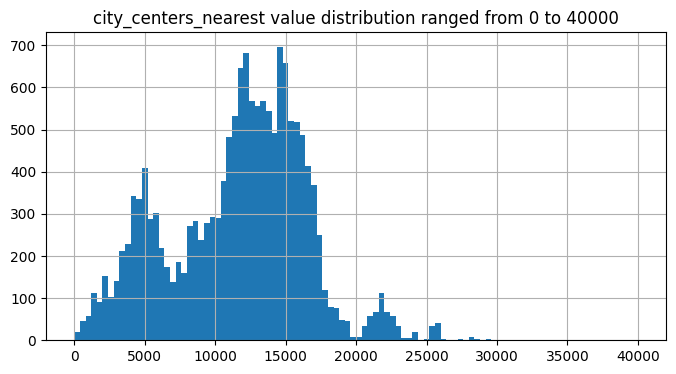

count    15660.000000
mean     11601.291571
std       4842.035279
min        181.000000
25%       8327.000000
50%      12244.500000
75%      14943.000000
max      29493.000000
Name: city_centers_nearest, dtype: float64

In [139]:
details(spb_realty['city_centers_nearest'], 40000) # somewhat random limit

На основе нескольких проверок было установлено, что значение в ~29,5 км до центра города - максимальное в подвыборке объявлений из Санкт-Петербурга. Значение count здесь немного меньше общего количества объявлений из этого города "благодаря" нескольким пропущенным значениям расстояния до центра.

Округлим значения расстояния в метрах до километров, выполним группировку, рассчитаем среднюю цену для каждого километра и построим линейный график средней цены в зависимости от расстояния до центра. 

In [140]:
spb_realty.loc[:, 'city_centers_nearest'] = round(spb_realty.loc[:, 'city_centers_nearest'] / 1000)

<AxesSubplot:xlabel='city_centers_nearest'>

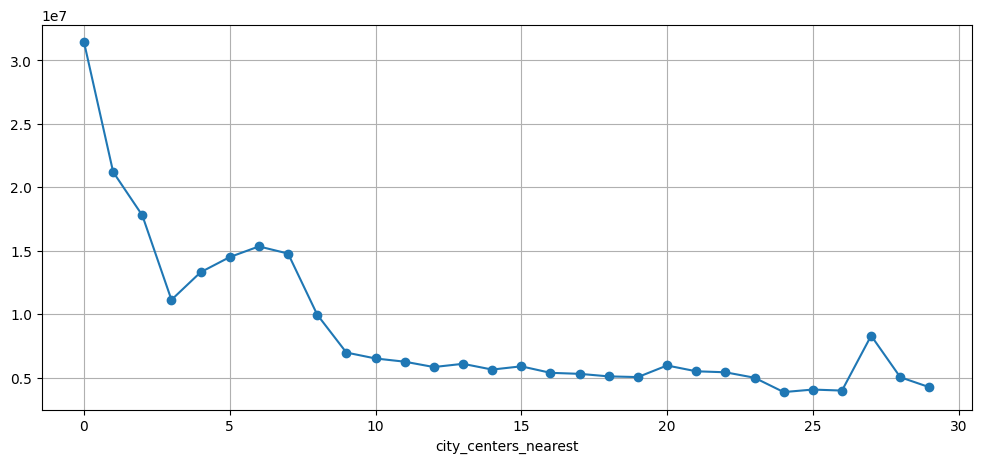

In [141]:
spb_realty.groupby(
    'city_centers_nearest')['last_price'].mean().plot(
        style='o-', grid=True, figsize=(12, 5))

Средняя цена недвижимости довольно устойчиво снижается на расстоянии до 3 километров, а затем снова начинает повышаться. Можно предположить, что примерно трехкилометровый радиус и составляет исторический центр Санкт-Петербурга. Причина снижения цены внутри этого радиуса может заключаться в плотной исторической застройке, которая совершенно не обязана предполагать недвижимость высокого качества и комфорта. Напротив: только за пределами исторического центра, где возможна застройка, появляется возможность предложить потребителям жилье высокого стандарта, чем может объясняться плавный рост средней цены на промежутке от 3 до 7 километров от исторического центра. Вклад фактора близости к центру в формировании цены уступает место фактору высоких потребительских свойств жилья.

Рассмотрим поближе "сегмент квартир в центре". В качестве радиуса центра Санкт-Петербурга возьмем 5 километров.

In [142]:
spb_realty_center = spb_realty.query('city_centers_nearest <= 5')
del spb_realty

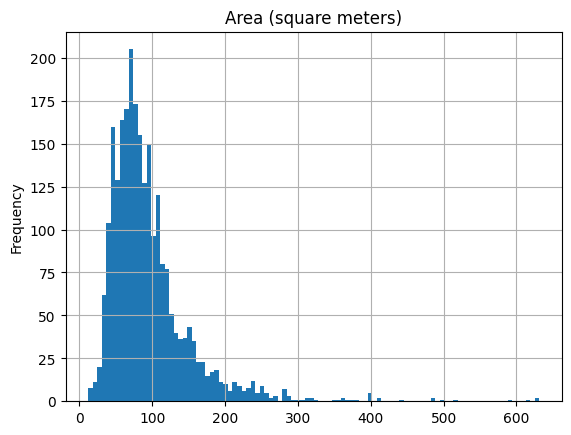

count    2487.000000
mean       95.637021
std        59.040476
min        12.000000
25%        60.050000
50%        82.000000
75%       112.100000
max       631.200000
Name: total_area, dtype: float64

In [143]:
spb_realty_center['total_area'].plot(kind='hist', grid=True, bins=100, title='Area (square meters)')
plt.show()
spb_realty_center['total_area'].describe()

Итак, основная доля квартир приходится на диапазон примерно от 50 до 100 кадратных метров. При это разброс значений вокруг среднего значения (которое чуть больше медианного) довольно велик, что говорит о довольно большом разнообразии площадей и метражей.

Мы уже знаем, что разброс стоимости недвижимости весьма велик, поэтому сразу поставим "верхнее" ограничение в 20 млн. руб.:

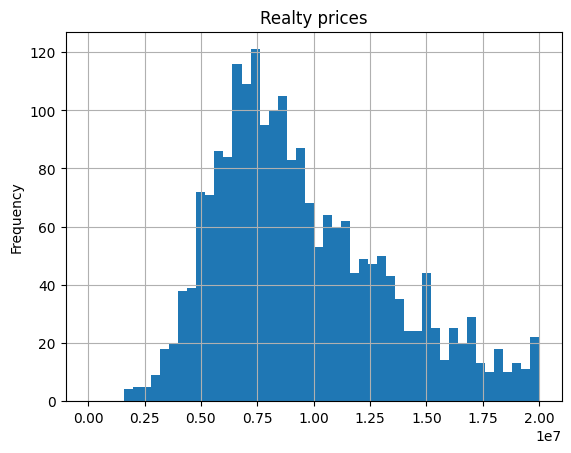

count    2.487000e+03
mean     1.480580e+07
std      2.611717e+07
min      1.600000e+06
25%      6.950000e+06
50%      9.500000e+06
75%      1.425000e+07
max      7.630000e+08
Name: last_price, dtype: float64

In [144]:
spb_realty_center['last_price'].plot(kind='hist', grid=True, bins=50,
                                     title='Realty prices', range=(0, 20000000))
plt.show()
spb_realty_center['last_price'].describe()

Стоимость недвижимости находится в сравнительно широком диапазоне с большими колебаниями, где основная доля предложений приходится на промежуток от примерно 4 млн. до 15 млн. руб.

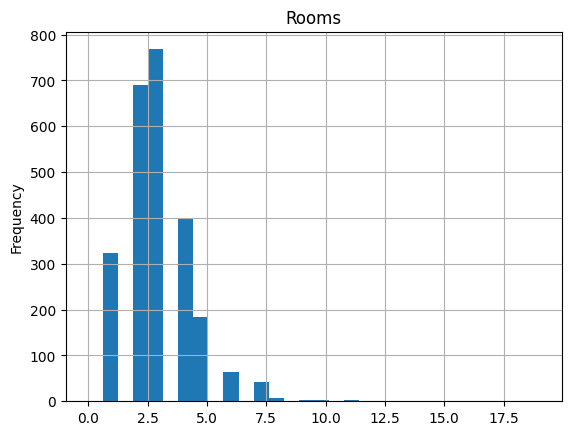

count    2487.000000
mean        2.970245
std         1.499504
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        19.000000
Name: rooms, dtype: float64

In [145]:
spb_realty_center['rooms'].plot(kind='hist', grid=True, bins=30, title='Rooms')
plt.show()
spb_realty_center['rooms'].describe()

Большинство предложений - в диапазоне от 2 до 4 комнат, причем двух-/трехкомнатных объектов гораздо больше, чем любых других.

Высота потолков преподносит небольшую неожиданность:

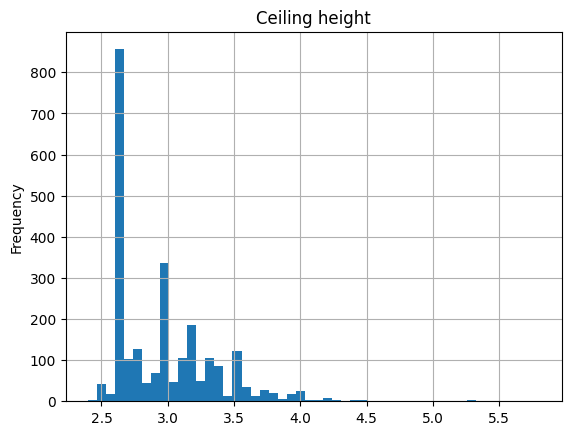

count    2487.000000
mean        2.977857
std         0.377418
min         2.400000
25%         2.650000
50%         2.900000
75%         3.200000
max         5.800000
Name: ceiling_height, dtype: float64

In [146]:
spb_realty_center['ceiling_height'].plot(kind='hist', grid=True, bins=50, title='Ceiling height')
plt.show()
spb_realty_center['ceiling_height'].describe()

Центр Санкт-Петербурга, если следовать стереотипам, - это старый жилой фонд с высокими потолками. И такого фонда наверняка немало. Более того, меры центральных тенденций говорят о том, что большинство объявлений - о недвижимости именно такого типа. Однако график показывает, что доля недвижимости со "средней" (до 2,7 м) высотой потолков как минимум очень заметна.

Теперь посмотрим, есть ли **связь между этими и некоторыми другими факторами и стоимостью недвижимости**.

Начнем с соотношения этажа, на котором находятся объекты недвижимости и её стоимости:

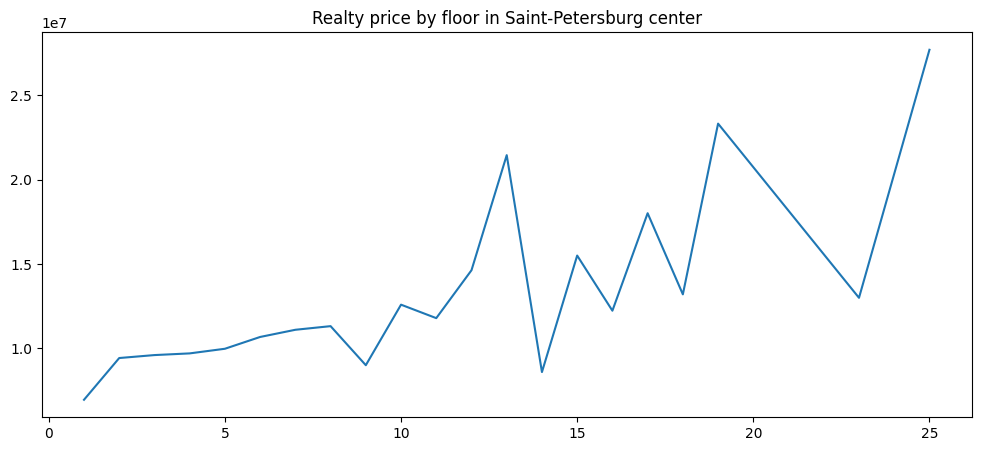

In [147]:
plt.figure(figsize=(12,5))
plt.plot(spb_realty_center.pivot_table(index='floor', values='last_price', aggfunc='median'))
plt.title('Realty price by floor in Saint-Petersburg center')
plt.show()

Распределение свидетельствует, что стоимость жилья повышается в зависимости от этажа, однако это повышение не выглядит очень значительно в пределах 1-6 этажа. В редких высоких зданиях центра Санкт-петербурга квартиры на высоких (7-10) этажах оцениваются выше, чем квартиры более низких этажей.

В общем можно сказать, что общий линейный тренд слегка намечается: медианная стоимость недвижимости растет с повышением этажности. Однако четко выраженного характера эта связь не имеет.

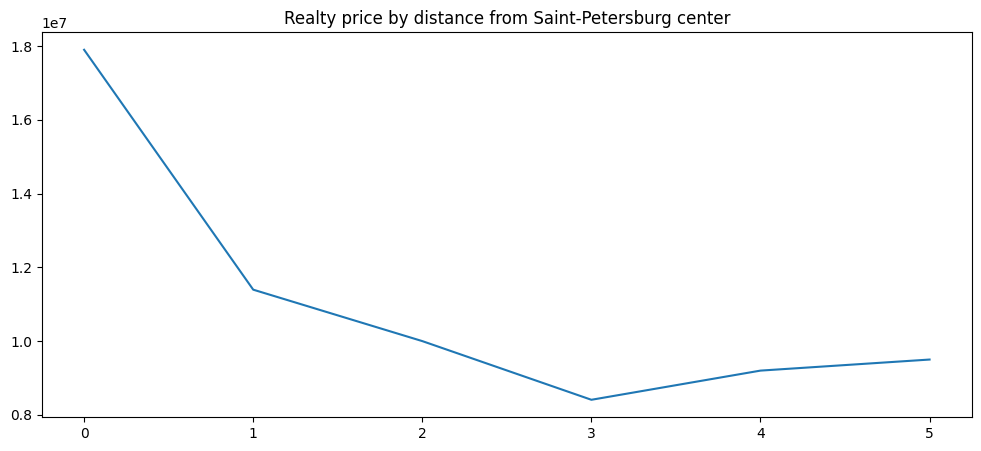

In [148]:
plt.figure(figsize=(12,5))
plt.plot(spb_realty_center.pivot_table(index='city_centers_nearest', values='last_price', aggfunc=('median')))
plt.title('Realty price by distance from Saint-Petersburg center')
plt.show()

Медианная стоимость недвижимости заметно падает при удалении от центра, что вполне объяснимо - чем ближе к нему, тем выше престиж владения им, даже если его потребительские свойства не столь высоки. Дальше медианная стоимость начинает расти, поскольку увеличивается доля "новостроя" с более высокой привлекательностью для приобретения. Поэтому сложно говорить о линейной связи в пределах центра Санкт-Петербурга между удаленностью от центра и стоимостью жилья, несмотря на наличие видимого снижения на первых трех километрах.

Теперь взглянем на связь стоимости жилья и количества комнат:

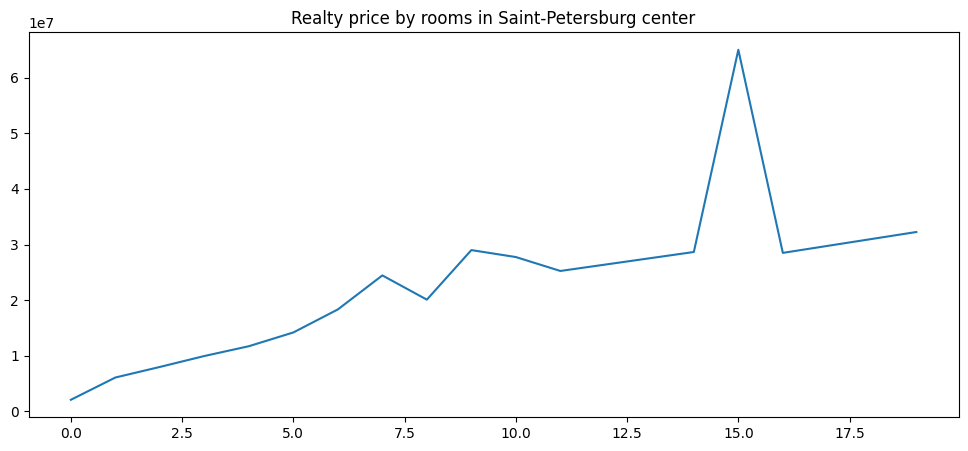

In [149]:
plt.figure(figsize=(12,5))
plt.plot(spb_realty_center.pivot_table(index='rooms', values='last_price', aggfunc=('median')))
plt.title('Realty price by rooms in Saint-Petersburg center')
plt.show()

Здесь наличие тренда очевидно. Количество комнат прямо связано с увеличением стоимости жилья. Этот тренж заметен на всем диапазоне, даже с учетом выброса в районе объектов с 15-ю комнатами.

Наконец, посмотрим на изменение цены в зависимости от года размещения объявления:

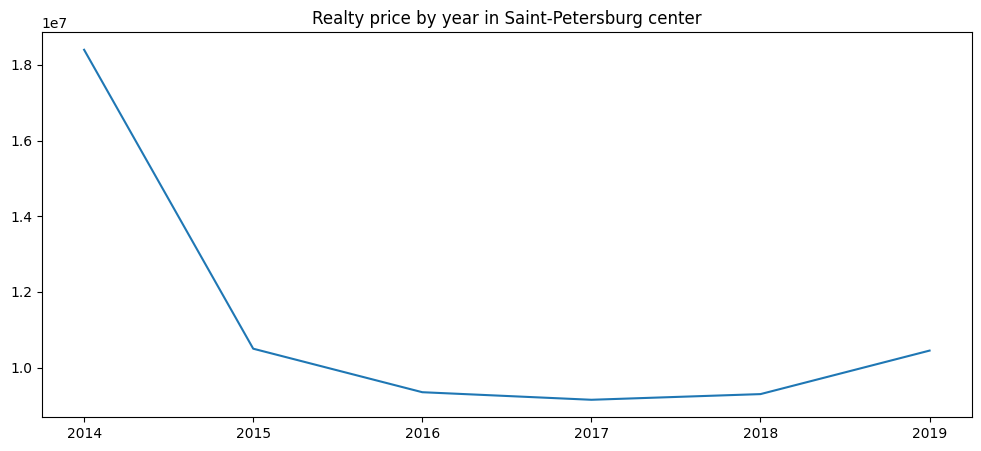

In [150]:
plt.figure(figsize=(12,5))
plt.plot(spb_realty_center.pivot_table(index='year_exposition', values='last_price', aggfunc=('median')))
plt.title('Realty price by year in Saint-Petersburg center')
plt.show()

Стоимость недвижимости в центре соответствует общему тренду на резкое снижение до 2018 года с дальнейшим медленным повышением. мы уже наблюдали этот тренд для всех объявлений в массиве данных. Линейный же тренд здесь отсутствует.

In [151]:
del spb_realty_center

## Общий вывод

В ходе проекта было установлено состояние ключевых параметров, определяющих рыночную стоимость жилья в Санкт-Петербурге и Ленинградской области. Выяснено распределение данных по стоимости, площади, количеству комнат, высоте потолков.

Подтверждена довольно разумная гипотеза о прямой связи стоимости объекта недвижимости и её площади (которая, в свою очередь, связана с количеством комнат). Для Санкт-Петербурга также подтверждена графическими методами гипотеза о прямой (не косвенной) связи между стоимостью недвижимости и количеством комнат в ней. При этом выявлено, что расстояние до центра, этаж и год размещения объявления не имеют четко и однозначно выраженной линейной связи со стоимостью недвижимости как минимум в центре Санкт-Петербурга. Однако прослеживается умеренная обратная связь расстояния до центра и стоимостьи недвижимости в пределах всего города.
Если принимать в расчет не только Санкт-Петербург, но и другие населенные пункты Ленинградской области, картина немного меняется. Можно выделить конкретный год (2014), когда медианная стоимость недвижимости была выше, чем в другие годы. Далее она снижалась вплоть до 2018 г., затем незначительно выросла в 2019-м. А вот количество объявлений было максимальным именно в 2017-2018 гг., что дает основания предположить причины снижения цены: банальный закон соотношения спроса и предложения. Стремясь сделать своё объявление более привлекательным, продавцы идут на незначительное снижение стоимости недвижимости - снова и снова.

Кроме того, распределение количеств объявлений по разных показателям дает основания для некоторых выводов о типичном "потребительском поведении" авторов объявлений о недвижимости:
- Объявления размещаются в основном в будние дни, что дает основания предположить, что пользователи занимаются этим важным делом в рабочие часы и, чего греха таить, с рабочего места. Однако это предположение для своего подтверждения требует отдельной специальной проверки (например, с помощью данных о времени размещения объявлений).
- Наиболее дорогие (по медианной стоимости) объекты выставляются по вторникам и средам.
- Наиболее "дорогой" месяц с точки зрения предложения недвижимости - апрель, самый дешевый - июнь.
- В целом период с февраля по апрель - самый активный по продаже недвижимости в выборке.